In [9]:
# Import standard libraries
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import warnings
from tqdm.notebook import tqdm

# Import NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from textblob import TextBlob
from wordcloud import WordCloud

# Import machine learning libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE

# Import web scraping and API libraries
import requests
from bs4 import BeautifulSoup
import praw  # For Reddit API instead of Twitter

# Import deep learning libraries (for transformer models)
import torch
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# Suppress warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Set random seed for reproducibility
np.random.seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# Reddit API configuration
reddit_client_id = "QDSyVD1LHShNCTJ9GonttQ"
reddit_client_secret = "fliMPeCskA3POs0lG8t1zoqRYAQzfw"
reddit_user_agent = "UyghurSentimentAnalysis by u/PogBOOM_69"

In [48]:
import praw

# Initialize the Reddit instance without login credentials
reddit = praw.Reddit(
    client_id=reddit_client_id,
    client_secret=reddit_client_secret,
    user_agent=reddit_user_agent,
    redirect_uri="http://localhost:8080"
)

# Test read-only access (doesn't require login)
try:
    print("Testing read-only API access...")
    for post in reddit.subreddit("Python").hot(limit=3):
        print(f"Post title: {post.title}")
    print("Read-only access successful!")
except Exception as e:
    print(f"API access failed: {e}")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Testing read-only API access...
Post title: Sunday Daily Thread: What's everyone working on this week?
Post title: Monday Daily Thread: Project ideas!
Post title: Does is actually matter that Python is a simple language?
Read-only access successful!


In [53]:
def collect_reddit_data(subreddit_names, search_terms, include_comments=True,
                           max_posts_per_search=15, max_posts_per_subreddit=30,
                           comment_limit=2, max_comments_per_post=20):
    """
    Fast Reddit data collection optimized for quicker runtime
    """
    import time
    from datetime import datetime
    from tqdm import tqdm
    import pandas as pd
    import praw
    import os
    import concurrent.futures

    # Create data directory if it doesn't exist
    os.makedirs('data', exist_ok=True)

    # Initialize the Reddit API client
    reddit = praw.Reddit(
        client_id=reddit_client_id,
        client_secret=reddit_client_secret,
        user_agent=reddit_user_agent
    )

    all_content = []

    # Function to process a single post
    def process_post(post, subreddit_name, term):
        post_results = []

        # Get post content
        post_data = {
            'id': post.id,
            'title': post.title,
            'text': post.selftext,
            'created_at': datetime.fromtimestamp(post.created_utc),
            'author': str(post.author),
            'score': post.score,
            'subreddit': subreddit_name,
            'num_comments': post.num_comments,
            'url': post.url,
            'is_comment': False,
            'parent_id': None,
            'search_term': term
        }
        post_results.append(post_data)

        # Get comments if needed
        if include_comments and post.num_comments > 0:
            try:
                # Limited comment expansion
                post.comments.replace_more(limit=comment_limit)
                comments = post.comments.list()

                # Only get top comments sorted by score
                sorted_comments = sorted(comments, key=lambda x: x.score if hasattr(x, 'score') else 0, reverse=True)
                top_comments = sorted_comments[:max_comments_per_post]

                for comment in top_comments:
                    try:
                        # Skip deleted/removed comments
                        if comment.author is None or comment.body in ['[deleted]', '[removed]']:
                            continue

                        comment_data = {
                            'id': comment.id,
                            'title': '',
                            'text': comment.body,
                            'created_at': datetime.fromtimestamp(comment.created_utc),
                            'author': str(comment.author),
                            'score': comment.score,
                            'subreddit': subreddit_name,
                            'num_comments': 0,
                            'url': f"https://www.reddit.com{comment.permalink}",
                            'is_comment': True,
                            'parent_id': post.id,
                            'search_term': term
                        }
                        post_results.append(comment_data)
                    except Exception:
                        continue
            except Exception:
                pass

        return post_results

    # Process each subreddit in parallel
    for subreddit_name in subreddit_names:
        subreddit_data = []
        posts_collected = 0

        try:
            subreddit = reddit.subreddit(subreddit_name)

            # Process each search term
            for term in search_terms:
                if posts_collected >= max_posts_per_subreddit:
                    break

                print(f"Searching for '{term}' in r/{subreddit_name}...")

                # Add rate limiting
                time.sleep(1.5)

                try:
                    # Calculate remaining posts to collect
                    current_limit = min(max_posts_per_search, max_posts_per_subreddit - posts_collected)
                    if current_limit <= 0:
                        continue

                    # Get posts from search
                    posts = list(subreddit.search(term, limit=current_limit, sort='relevance'))

                    # Process posts in parallel
                    post_results = []
                    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
                        future_to_post = {
                            executor.submit(process_post, post, subreddit_name, term): post
                            for post in posts
                        }

                        for future in concurrent.futures.as_completed(future_to_post):
                            results = future.result()
                            post_results.extend(results)

                    # Update counts and add to collection
                    new_posts = [r for r in post_results if not r['is_comment']]
                    posts_collected += len(new_posts)
                    subreddit_data.extend(post_results)

                    print(f"Collected {len(new_posts)} posts and {len(post_results) - len(new_posts)} comments from r/{subreddit_name} with term '{term}'")

                except Exception as e:
                    print(f"Error searching for '{term}' in r/{subreddit_name}: {e}")
                    if "429" in str(e):
                        print("Rate limit hit, waiting 30 seconds...")
                        time.sleep(30)
                    continue

            # Save interim results for this subreddit
            if subreddit_data:
                all_content.extend(subreddit_data)
                interim_df = pd.DataFrame(subreddit_data)
                interim_df.to_csv(f'data/interim_reddit_{subreddit_name}.csv', index=False)
                print(f"Saved {len(interim_df)} items from r/{subreddit_name}")

        except Exception as e:
            print(f"Error processing subreddit r/{subreddit_name}: {e}")
            continue

    # Final processing
    if not all_content:
        print("No data collected!")
        return pd.DataFrame()

    df = pd.DataFrame(all_content)

    # Remove duplicates
    df = df.drop_duplicates(subset=['id'])
    print(f"Final dataset after removing duplicates: {len(df)} items")

    return df

In [ ]:
def collect_reddit_data_enhanced(subreddit_names, search_terms, include_comments=True,
                                max_posts_per_search=50, max_posts_per_subreddit=None,
                                comment_limit=3, max_comments_per_post=50):
    """
    Enhanced Reddit data collection with focus on multiple search terms

    Parameters:
    - subreddit_names: List of subreddits to search
    - search_terms: List of search terms to use
    - include_comments: Whether to collect comments
    - max_posts_per_search: Maximum posts per individual search term
    - max_posts_per_subreddit: Optional cap on total posts per subreddit
    - comment_limit: How many levels of comments to expand
    - max_comments_per_post: Maximum comments to collect per post
    """
    # Initialize the Reddit API client
    reddit = praw.Reddit(
        client_id=reddit_client_id,
        client_secret=reddit_client_secret,
        user_agent=reddit_user_agent
    )

    all_content = []
    posts_collected_per_subreddit = {subreddit: 0 for subreddit in subreddit_names}
    total_posts = 0
    total_comments = 0

    # Track posts we've seen to avoid duplicates
    seen_post_ids = set()

    # For each subreddit
    for subreddit_name in subreddit_names:
        # Check if we've hit the maximum for this subreddit
        if max_posts_per_subreddit and posts_collected_per_subreddit[subreddit_name] >= max_posts_per_subreddit:
            print(f"Reached limit of {max_posts_per_subreddit} posts for r/{subreddit_name}, moving to next subreddit")
            continue

        try:
            subreddit = reddit.subreddit(subreddit_name)

            # For each search term (important to iterate through ALL terms)
            for term in search_terms:
                print(f"Searching for '{term}' in r/{subreddit_name}...")

                # Check if we've hit the maximum for this subreddit
                if max_posts_per_subreddit and posts_collected_per_subreddit[subreddit_name] >= max_posts_per_subreddit:
                    print(f"Reached limit of {max_posts_per_subreddit} posts for r/{subreddit_name}, moving to next search term")
                    break

                # Collect posts matching search term
                try:
                    post_count = 0

                    # Use search method with explicit term parameter
                    for post in subreddit.search(term, limit=max_posts_per_search):
                        # Skip if we've seen this post before
                        if post.id in seen_post_ids:
                            continue

                        # Add post to seen set
                        seen_post_ids.add(post.id)

                        # Add post data
                        post_data = {
                            'id': post.id,
                            'title': post.title,
                            'text': post.selftext,
                            'created_at': datetime.fromtimestamp(post.created_utc),
                            'author': str(post.author),
                            'score': post.score,
                            'subreddit': subreddit_name,
                            'num_comments': post.num_comments,
                            'url': post.url,
                            'is_comment': False,
                            'parent_id': None,
                            'search_term': term  # Track which search term found this post
                        }
                        all_content.append(post_data)
                        total_posts += 1
                        post_count += 1
                        posts_collected_per_subreddit[subreddit_name] += 1

                        # Collect comments if requested
                        if include_comments:
                            try:
                                # Replace more comments up to specified limit
                                post.comments.replace_more(limit=comment_limit)
                                comments = post.comments.list()[:max_comments_per_post]

                                for comment in comments:
                                    try:
                                        # Skip deleted/removed comments
                                        if comment.author is None or comment.body in ['[deleted]', '[removed]']:
                                            continue

                                        comment_data = {
                                            'id': comment.id,
                                            'title': '',
                                            'text': comment.body,
                                            'created_at': datetime.fromtimestamp(comment.created_utc),
                                            'author': str(comment.author),
                                            'score': comment.score,
                                            'subreddit': subreddit_name,
                                            'num_comments': 0,
                                            'url': f"https://www.reddit.com{comment.permalink}",
                                            'is_comment': True,
                                            'parent_id': post.id,
                                            'search_term': term  # Track which search term led to this comment
                                        }
                                        all_content.append(comment_data)
                                        total_comments += 1
                                    except Exception as e:
                                        print(f"Error processing comment {comment.id}: {e}")
                            except Exception as e:
                                print(f"Error collecting comments for post {post.id}: {e}")

                        # Print progress
                        if post_count % 10 == 0:
                            print(f"Collected {post_count} posts for term '{term}' in r/{subreddit_name}")

                        # Check if we've hit the maximum for this subreddit
                        if max_posts_per_subreddit and posts_collected_per_subreddit[subreddit_name] >= max_posts_per_subreddit:
                            print(f"Reached limit of {max_posts_per_subreddit} posts for r/{subreddit_name}, moving to next search term")
                            break

                    print(f"Collected {post_count} posts for term '{term}' in r/{subreddit_name}")

                except Exception as e:
                    print(f"Error searching for term '{term}' in r/{subreddit_name}: {e}")
                    continue

        except Exception as e:
            print(f"Error accessing subreddit r/{subreddit_name}: {e}")
            continue

    print(f"\nTotal collection complete. Collected {total_posts} posts and {total_comments} comments")

    # Create DataFrame
    df = pd.DataFrame(all_content)

    # Remove any duplicates that slipped through
    if not df.empty:
        df = df.drop_duplicates(subset=['id'])
        print(f"Final dataset after removing duplicates: {len(df)} items")

    return df

# Expanded search terms focusing on potentially negative content
negative_search_terms = [
    'Uyghur genocide',
    'Uyghur camps',
    'Xinjiang camps',
    're-education camp',
    'forced labor Uyghur',
    'Uyghur detention',
    'Uyghur persecution',
    'cultural genocide Uyghur',
    'Uyghur sterilization',
    'Uyghur concentration camp'
]

# Add these to your original search terms
all_search_terms = [
    'Uyghur', 'Uighur', 'Xinjiang', 'East Turkestan',
    'Uyghur diaspora', 'Uyghur culture', 'Uyghur refugee'
] + negative_search_terms

# Expanded subreddit list to include more politically focused ones
uyghur_subreddits = [
    'worldnews', 'China', 'geopolitics', 'Uyghur',
    'humanrights', 'Xinjiang', 'islam',
    'politics', 'news', 'UyghurPlight',
    'FreeTheUyghurs', 'GenZedong', 'fucktheccp',
    'Sino'  # Known for pro-China perspective, might provide contrast
]

# Create data directory if it doesn't exist
import os
os.makedirs('data', exist_ok=True)

# Collect Reddit data with enhanced search terms
reddit_data_enhanced_df = collect_reddit_data_enhanced(
    uyghur_subreddits,
    all_search_terms,
    include_comments=True,
    max_posts_per_search=30,  # Limit per search term to stay within rate limits
    max_posts_per_subreddit=100,  # Cap total posts per subreddit
    comment_limit=2,  # Expand comments to 2 levels deep
    max_comments_per_post=30  # Get up to 30 comments per post
)

# Save to CSV
reddit_data_enhanced_df.to_csv('data/uyghur_reddit_enhanced.csv', index=False)

In [54]:
import os

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Focus on the most active/relevant subreddits for faster results
uyghur_subreddits = ['worldnews', 'China', 'geopolitics', 'Uyghur', 'humanrights',
                     'Xinjiang', 'islam', 'Sino', 'FreeTheUyghurs', 'fucktheccp',
                     'Muslim', 'CCP_virus', 'politics']

# Focus on the most common search terms
uyghur_search_terms = ['Uyghur', 'Uighur', 'genocide', 're-education camp', 'East Turkestan']

# Collect Reddit posts with fast function
reddit_data_df = collect_reddit_data(
    uyghur_subreddits,
    uyghur_search_terms,
    include_comments=True,
    max_posts_per_search=50,     # More aggressive post limit
    max_posts_per_subreddit=50,  # More aggressive subreddit limit
    comment_limit=2,             # Only expand 2 levels of comments
    max_comments_per_post=50     # Only get 50 top comments
)

# Save to CSV
reddit_data_df.to_csv('data/uyghur_reddit_fast.csv', index=False)

print(f"Collected {len(reddit_data_df)} Reddit items")

Searching for 'Uyghur' in r/worldnews...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 50 posts and 1804 comments from r/worldnews with term 'Uyghur'
Saved 1854 items from r/worldnews
Searching for 'Uyghur' in r/China...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 50 posts and 2088 comments from r/China with term 'Uyghur'
Saved 2138 items from r/China
Searching for 'Uyghur' in r/geopolitics...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 50 posts and 1338 comments from r/geopolitics with term 'Uyghur'
Saved 1388 items from r/geopolitics
Searching for 'Uyghur' in r/Uyghur...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 50 posts and 270 comments from r/Uyghur with term 'Uyghur'
Saved 320 items from r/Uyghur
Searching for 'Uyghur' in r/humanrights...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 50 posts and 6 comments from r/humanrights with term 'Uyghur'
Saved 56 items from r/humanrights
Searching for 'Uyghur' in r/Xinjiang...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 50 posts and 19 comments from r/Xinjiang with term 'Uyghur'
Saved 69 items from r/Xinjiang
Searching for 'Uyghur' in r/islam...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 50 posts and 1412 comments from r/islam with term 'Uyghur'
Saved 1462 items from r/islam
Searching for 'Uyghur' in r/Sino...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 50 posts and 1348 comments from r/Sino with term 'Uyghur'
Saved 1398 items from r/Sino
Searching for 'Uyghur' in r/FreeTheUyghurs...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 50 posts and 135 comments from r/FreeTheUyghurs with term 'Uyghur'
Saved 185 items from r/FreeTheUyghurs
Searching for 'Uyghur' in r/fucktheccp...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 50 posts and 1257 comments from r/fucktheccp with term 'Uyghur'
Saved 1307 items from r/fucktheccp
Searching for 'Uyghur' in r/Muslim...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 50 posts and 227 comments from r/Muslim with term 'Uyghur'
Saved 277 items from r/Muslim
Searching for 'Uyghur' in r/CCP_virus...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 50 posts and 229 comments from r/CCP_virus with term 'Uyghur'
Saved 279 items from r/CCP_virus
Searching for 'Uyghur' in r/politics...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 50 posts and 980 comments from r/politics with term 'Uyghur'
Saved 1030 items from r/politics
Final dataset after removing duplicates: 11763 items
Collected 11763 Reddit items


In [75]:
# Text preprocessing function
def preprocess_text(text, remove_stopwords=True, lemmatize=True):
    # Check if text is NaN
    if pd.isna(text) or text == "":
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove Reddit-specific formatting
    text = re.sub(r'\[deleted\]|\[removed\]', '', text)
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'&lt;|&gt;', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        # Add Reddit-specific stopwords
        reddit_stopwords = {'reddit', 'upvote', 'downvote', 'karma', 'subreddit', 'edit', 'deleted', 'removed'}
        stop_words.update(reddit_stopwords)
        tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Rejoin tokens
    processed_text = ' '.join(tokens)

    return processed_text

In [76]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [77]:
# Load the Reddit data
# reddit_data_df = pd.read_csv('data/uyghur_reddit_fast.csv')
reddit_data_df = pd.read_csv('data/uyghur_reddit_enhanced.csv')

# Combine title and text for posts (for more comprehensive analysis)
reddit_data_df['combined_text'] = reddit_data_df.apply(
    lambda row: (str(row['title']) + ' ' + str(row['text'])) if not row['is_comment'] else str(row['text']),
    axis=1
)

# Apply preprocessing
reddit_data_df['processed_content'] = reddit_data_df['combined_text'].apply(preprocess_text)

# Convert 'created_at' to datetime if it's not already
if 'created_at' in reddit_data_df.columns:
    reddit_data_df['created_at'] = pd.to_datetime(reddit_data_df['created_at'])

# Display a sample before and after preprocessing
sample_idx = 0
print("Original text:")
print(reddit_data_df.iloc[sample_idx]['combined_text'][:500])  # Truncate to first 500 chars
print("\nProcessed text:")
print(reddit_data_df.iloc[sample_idx]['processed_content'][:500])  # Truncate to first 500 chars

Original text:
'This may be my last message': Uyghurs stage hunger strike over China deportation nan

Processed text:
may last message uyghurs stage hunger strike china deportation nan


Dataset source distribution:
subreddit
China             2478
news              2278
worldnews         2087
Sino              1835
geopolitics       1805
islam             1786
politics          1713
fucktheccp        1661
Uyghur             539
FreeTheUyghurs     474
Name: count, dtype: int64

Content type distribution:
is_comment
Comment    15767
Post        1200
Name: count, dtype: int64


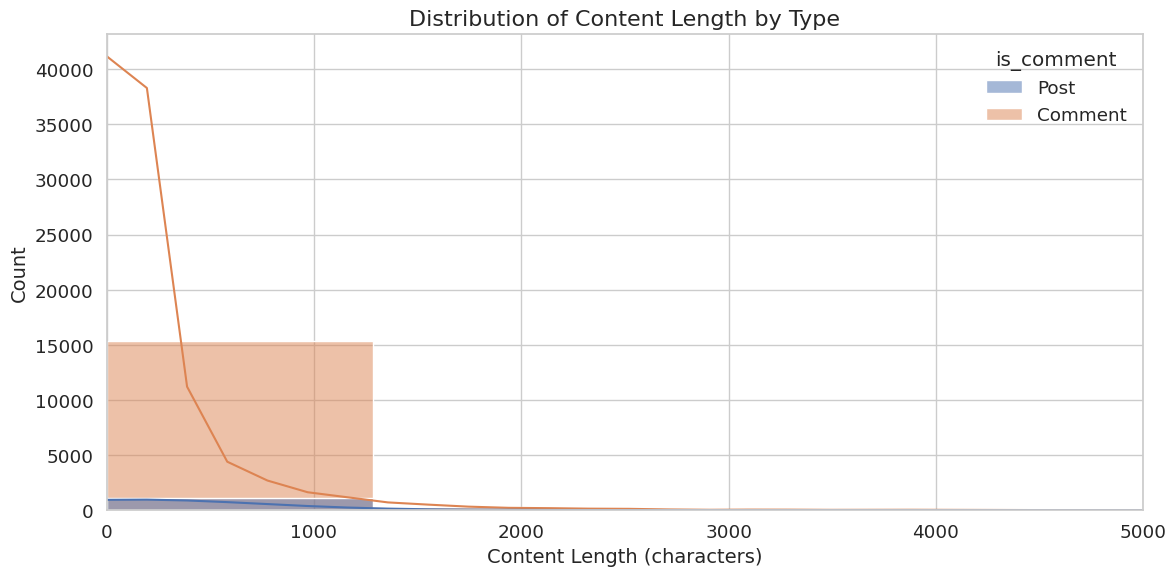


Content length statistics by type:
              count        mean          std   min   25%    50%    75%  \
is_comment                                                               
Comment     15767.0  260.895605   513.836865   1.0  58.0  119.0  264.0   
Post         1200.0  475.655833  2442.950668  20.0  73.0   95.0  176.0   

                max  
is_comment           
Comment      9508.0  
Post        38564.0  


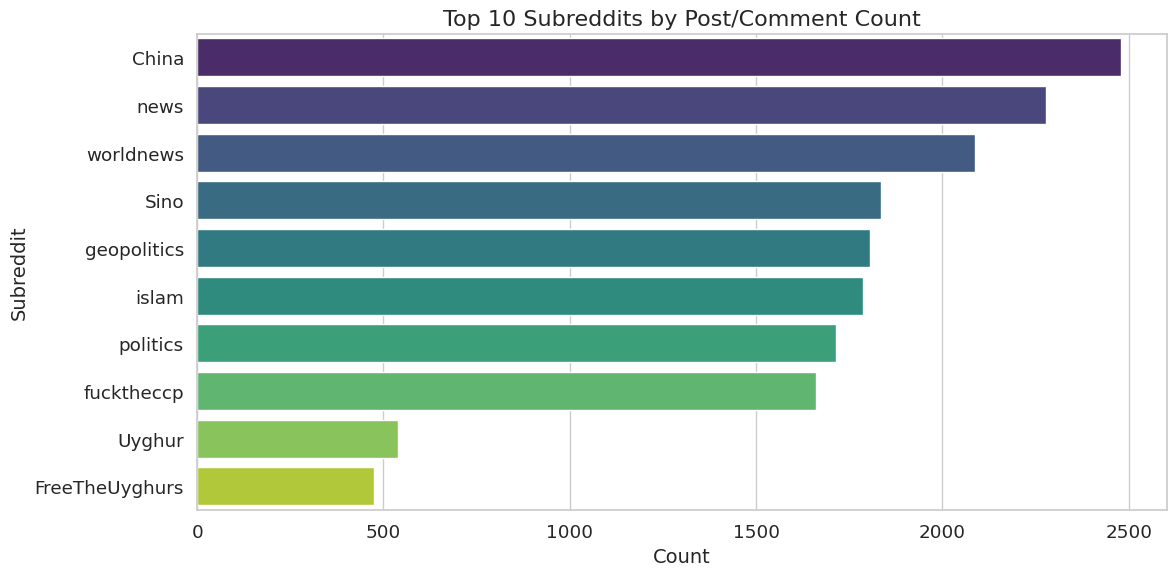

<Figure size 1400x600 with 0 Axes>

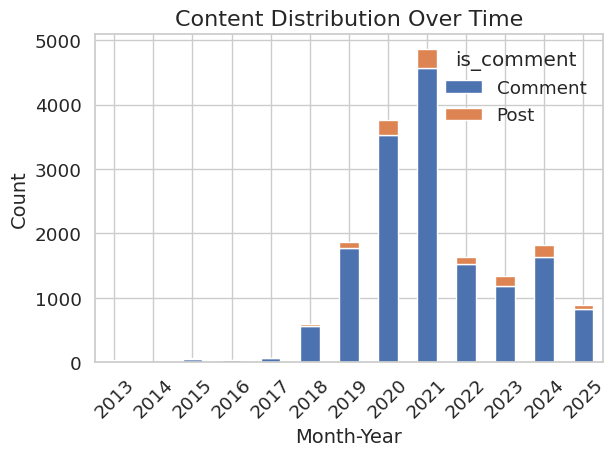

In [78]:
# Basic Statistics and Distributions
print("Dataset source distribution:")
print(reddit_data_df['subreddit'].value_counts().head(10))  # Show top 10 subreddits

print("\nContent type distribution:")
content_type_counts = reddit_data_df['is_comment'].map({True: 'Comment', False: 'Post'}).value_counts()
print(content_type_counts)

# Calculate text length
reddit_data_df['content_length'] = reddit_data_df['combined_text'].apply(len)

# Content length distribution by type
plt.figure(figsize=(12, 6))
sns.histplot(data=reddit_data_df, x='content_length',
             hue=reddit_data_df['is_comment'].map({True: 'Comment', False: 'Post'}),
             kde=True, bins=30)
plt.title('Distribution of Content Length by Type', fontsize=16)
plt.xlabel('Content Length (characters)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(0, 5000)  # Limit x-axis for better visualization
plt.tight_layout()
plt.show()

# Content length statistics by type
print("\nContent length statistics by type:")
print(reddit_data_df.groupby(reddit_data_df['is_comment'].map({True: 'Comment', False: 'Post'}))['content_length'].describe())

# Top subreddits visualization
top_n_subreddits = 10
subreddit_counts = reddit_data_df['subreddit'].value_counts().head(top_n_subreddits)

plt.figure(figsize=(12, 6))
sns.barplot(x=subreddit_counts.values, y=subreddit_counts.index, palette='viridis')
plt.title(f'Top {top_n_subreddits} Subreddits by Post/Comment Count', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Subreddit', fontsize=14)
plt.tight_layout()
plt.show()

# Content over time
if 'created_at' in reddit_data_df.columns:
    # Extract year and month
    reddit_data_df['year'] = reddit_data_df['created_at'].dt.year
    reddit_data_df['month'] = reddit_data_df['created_at'].dt.month
    reddit_data_df['month_year'] = reddit_data_df['created_at'].dt.strftime('%Y-%m')

    # Plot time distribution
    plt.figure(figsize=(14, 6))
    content_by_month = reddit_data_df.groupby(['year', reddit_data_df['is_comment'].map({True: 'Comment', False: 'Post'})]).size().unstack()
    content_by_month.plot(kind='bar', stacked=True)
    plt.title('Content Distribution Over Time', fontsize=16)
    plt.xlabel('Month-Year', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

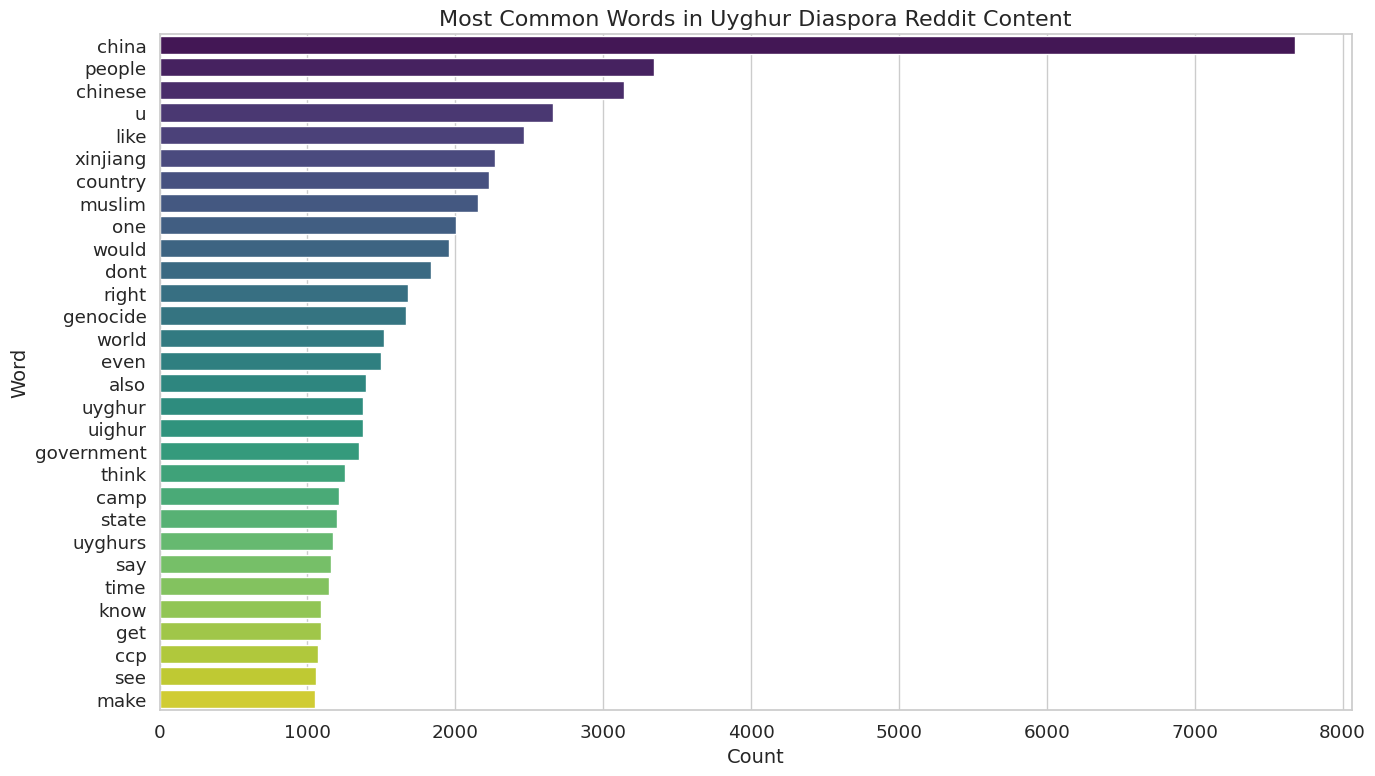

<Figure size 1600x1000 with 0 Axes>

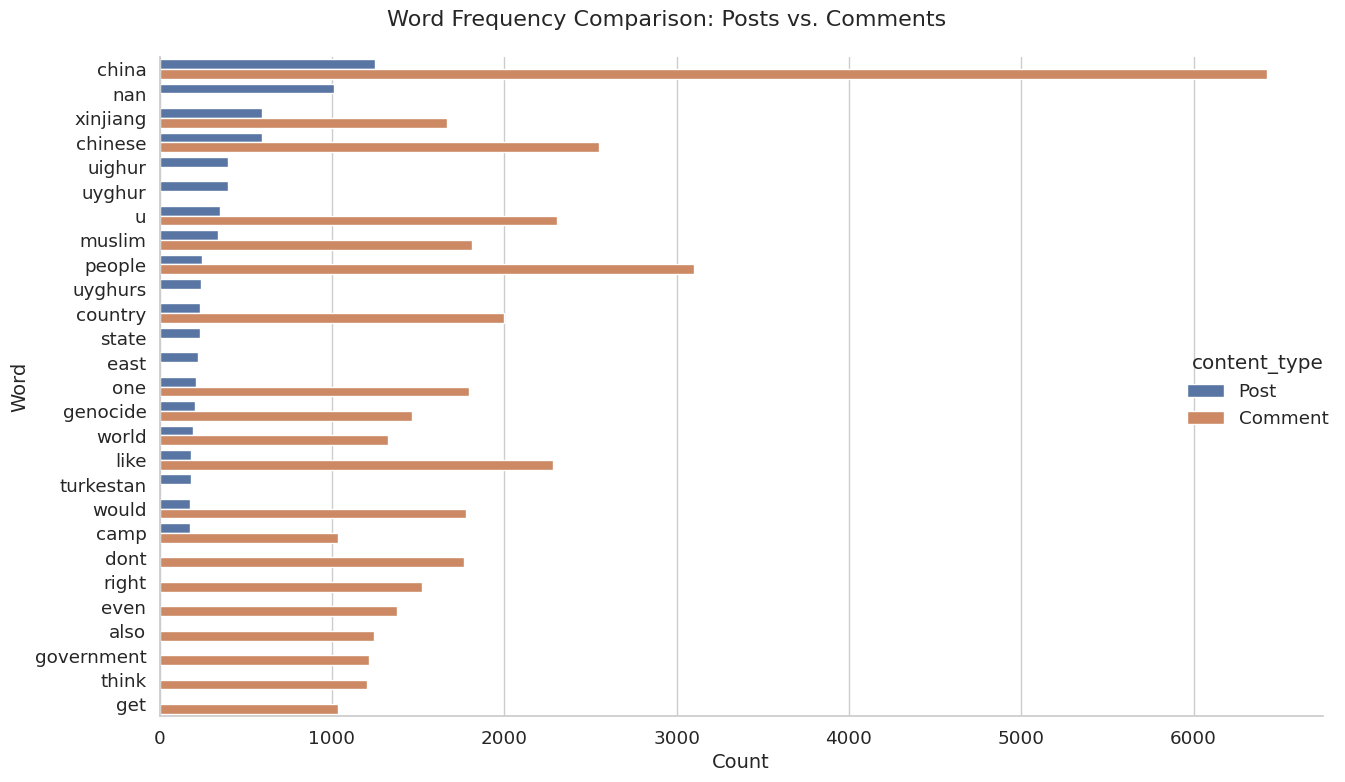


Top words in r/China:
china: 996
people: 610
chinese: 508
xinjiang: 503
genocide: 427
like: 388
u: 285
would: 281
country: 272
uyghur: 260
dont: 257
one: 255
ccp: 255
muslim: 245
camp: 241

Top words in r/news:
china: 940
people: 379
chinese: 328
like: 307
u: 287
right: 225
country: 216
dont: 202
one: 193
would: 182
world: 174
uighur: 173
government: 170
genocide: 165
get: 160

Top words in r/worldnews:
china: 935
people: 362
u: 289
country: 281
like: 258
chinese: 254
right: 254
xinjiang: 226
muslim: 224
genocide: 222
world: 216
one: 213
dont: 201
would: 184
uighur: 177


In [79]:
# Function to extract most common words
def get_common_words(texts, n=20):
    # Join all texts
    all_words = ' '.join(texts).split()
    # Count words
    word_counts = Counter(all_words)
    # Return most common
    return word_counts.most_common(n)

# Get most common words in the entire dataset
most_common_words = get_common_words(reddit_data_df['processed_content'].dropna(), n=30)

# Create DataFrame for visualization
common_words_df = pd.DataFrame(most_common_words, columns=['word', 'count'])

# Plot most common words
plt.figure(figsize=(14, 8))
sns.barplot(data=common_words_df, x='count', y='word', palette='viridis')
plt.title('Most Common Words in Uyghur Diaspora Reddit Content', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Word', fontsize=14)
plt.tight_layout()
plt.show()

# Compare word frequencies between posts and comments
post_words = get_common_words(
    reddit_data_df[~reddit_data_df['is_comment']]['processed_content'].dropna(),
    n=20
)
comment_words = get_common_words(
    reddit_data_df[reddit_data_df['is_comment']]['processed_content'].dropna(),
    n=20
)

# Create DataFrames
post_words_df = pd.DataFrame(post_words, columns=['word', 'count'])
post_words_df['content_type'] = 'Post'
comment_words_df = pd.DataFrame(comment_words, columns=['word', 'count'])
comment_words_df['content_type'] = 'Comment'

# Combine for comparison
comparison_df = pd.concat([post_words_df, comment_words_df])

# Plot comparison
plt.figure(figsize=(16, 10))
g = sns.catplot(data=comparison_df, x='count', y='word', hue='content_type', kind='bar', height=8, aspect=1.5)
g.fig.suptitle('Word Frequency Comparison: Posts vs. Comments', fontsize=16)
g.set_xlabels('Count', fontsize=14)
g.set_ylabels('Word', fontsize=14)
plt.tight_layout()
plt.show()

# Compare word frequencies by subreddit (top 3 subreddits)
top_subreddits = reddit_data_df['subreddit'].value_counts().head(3).index.tolist()
for subreddit in top_subreddits:
    subreddit_words = get_common_words(
        reddit_data_df[reddit_data_df['subreddit'] == subreddit]['processed_content'].dropna(),
        n=15
    )
    print(f"\nTop words in r/{subreddit}:")
    for word, count in subreddit_words:
        print(f"{word}: {count}")

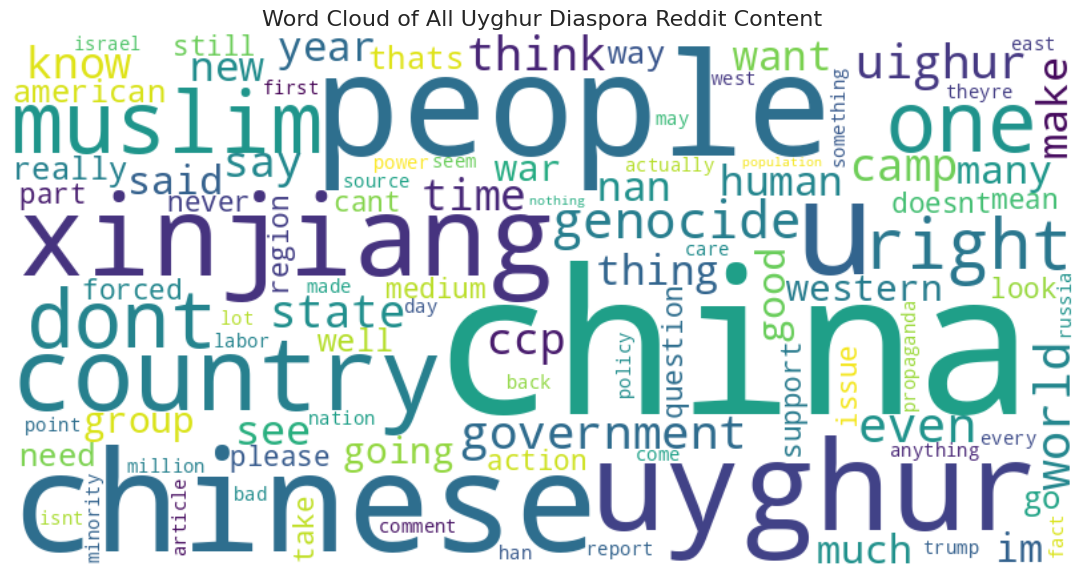

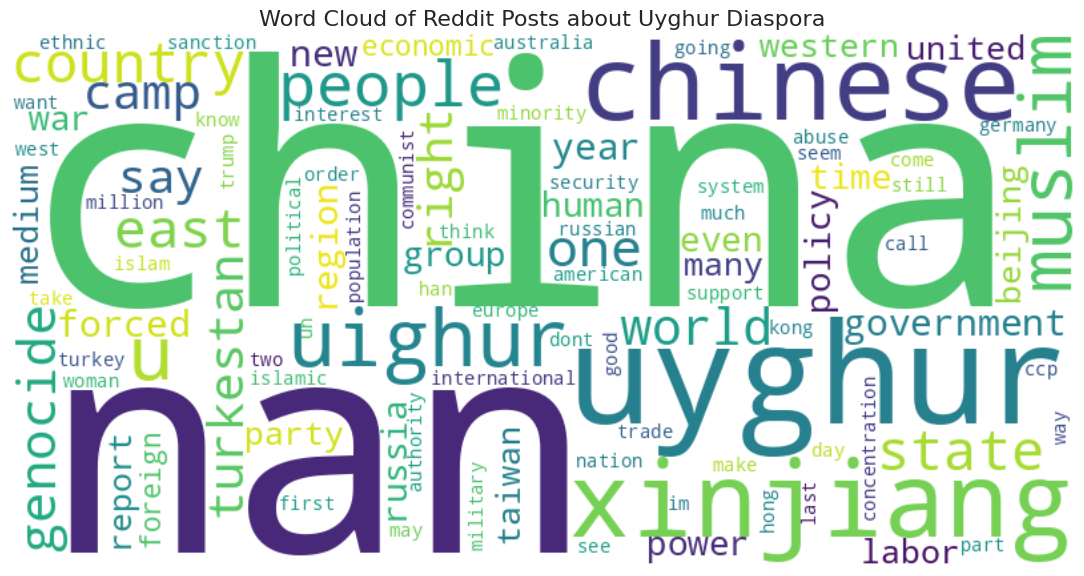

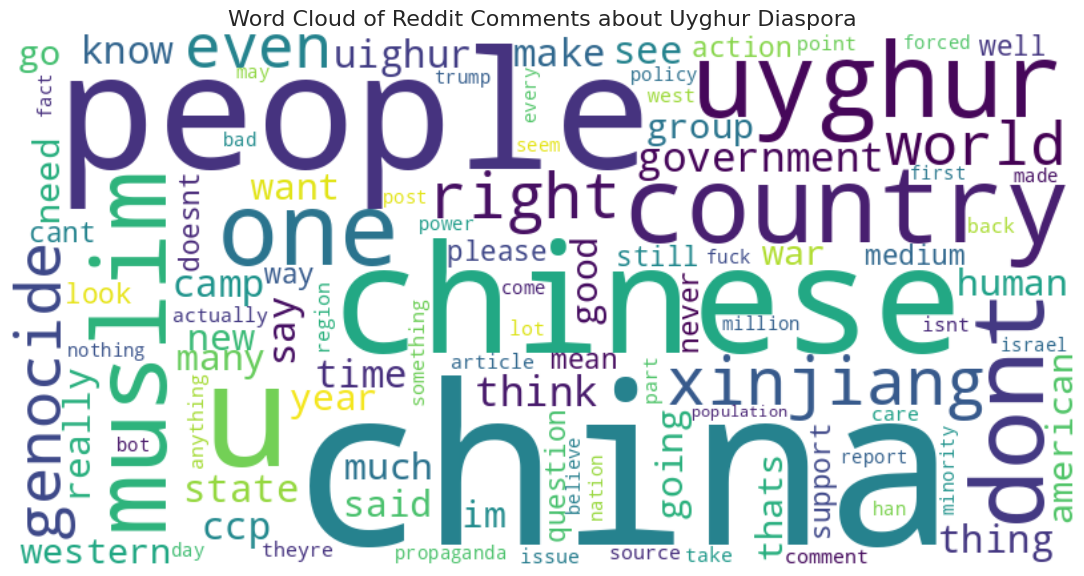

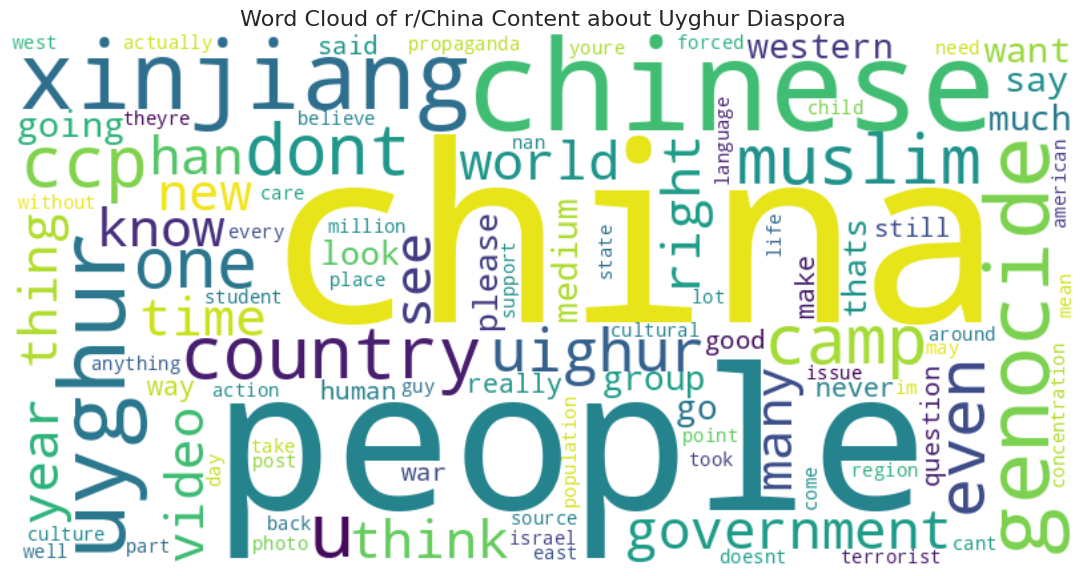

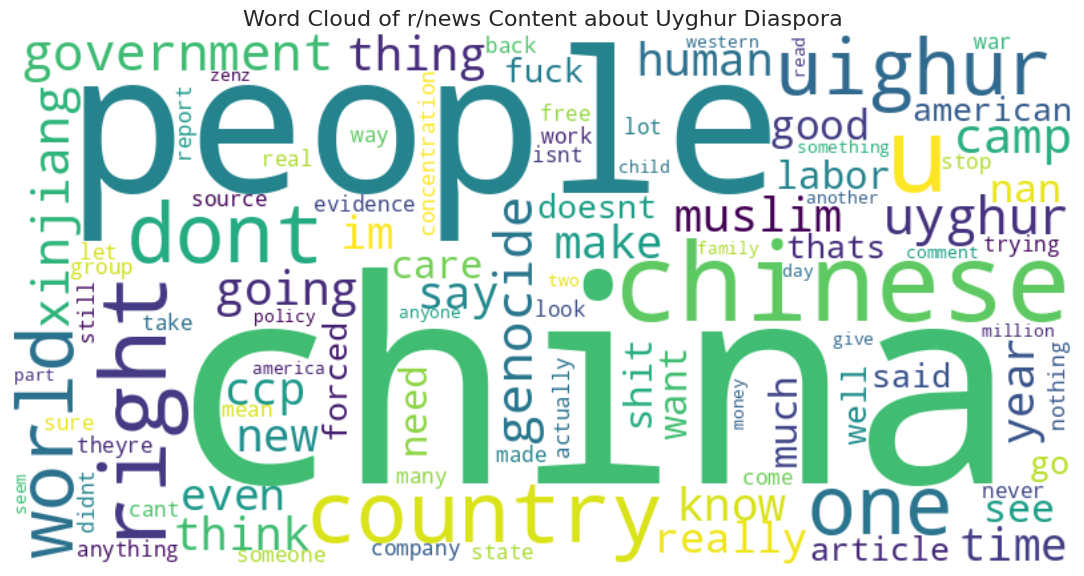

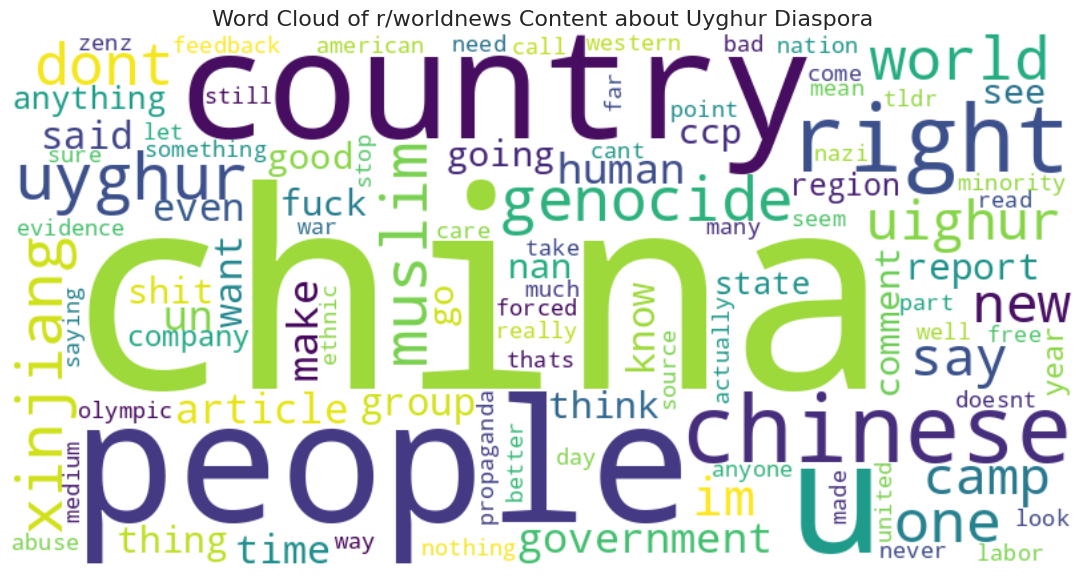

In [80]:
# Create word clouds for the entire dataset and by content type
def create_wordcloud(text, title, max_words=100):
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=max_words, collocations=False).generate(text)

    # Display the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Word cloud for all content
all_text = ' '.join(reddit_data_df['processed_content'].dropna())
create_wordcloud(all_text, 'Word Cloud of All Uyghur Diaspora Reddit Content')

# Word cloud for posts
posts_text = ' '.join(reddit_data_df[~reddit_data_df['is_comment']]['processed_content'].dropna())
create_wordcloud(posts_text, 'Word Cloud of Reddit Posts about Uyghur Diaspora')

# Word cloud for comments
comments_text = ' '.join(reddit_data_df[reddit_data_df['is_comment']]['processed_content'].dropna())
create_wordcloud(comments_text, 'Word Cloud of Reddit Comments about Uyghur Diaspora')

# Word clouds for top subreddits
for subreddit in top_subreddits:
    subreddit_text = ' '.join(
        reddit_data_df[reddit_data_df['subreddit'] == subreddit]['processed_content'].dropna()
    )
    if subreddit_text.strip():  # Only create if there's text
        create_wordcloud(
            subreddit_text,
            f'Word Cloud of r/{subreddit} Content about Uyghur Diaspora'
        )

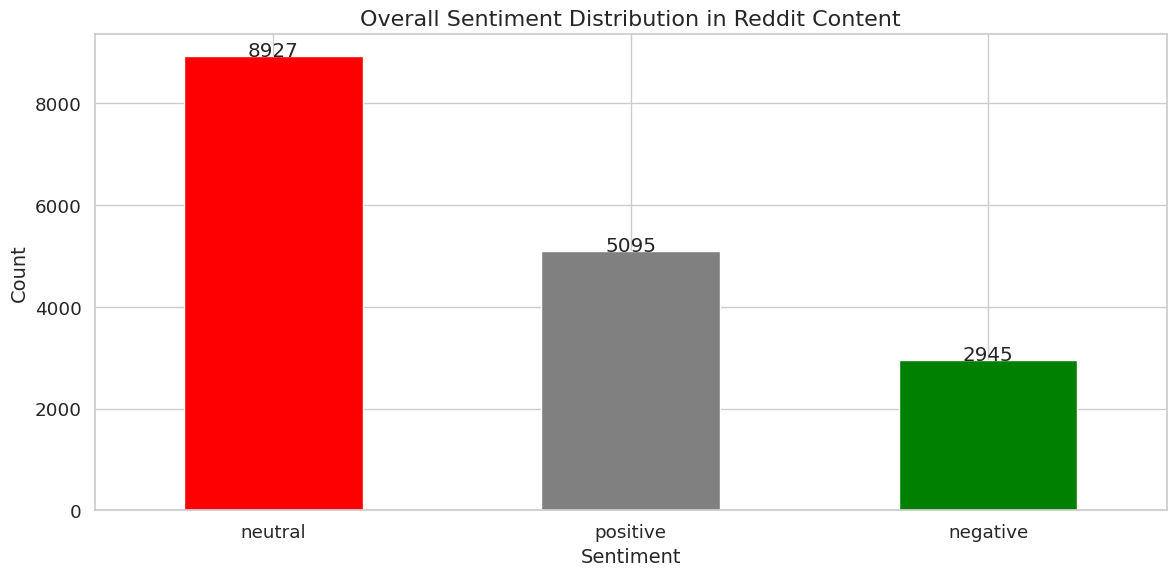

<Figure size 1400x600 with 0 Axes>

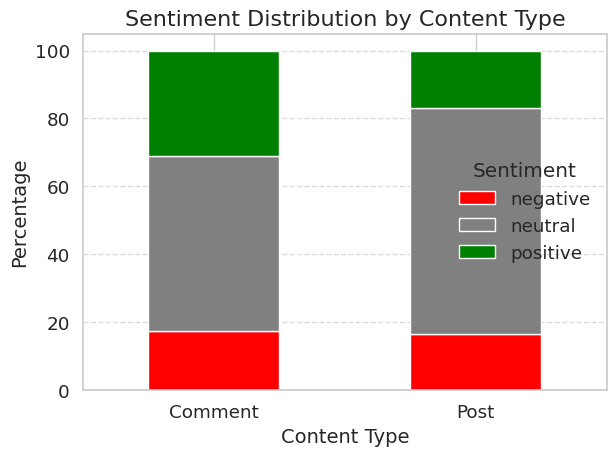

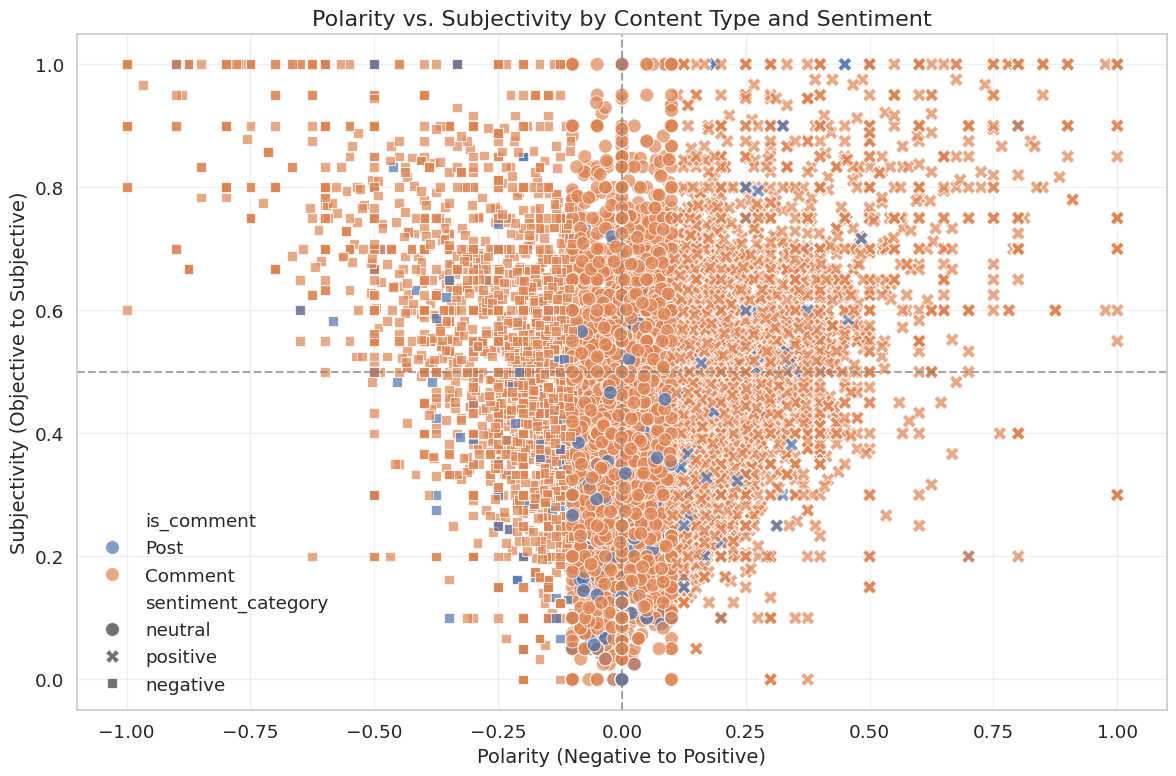

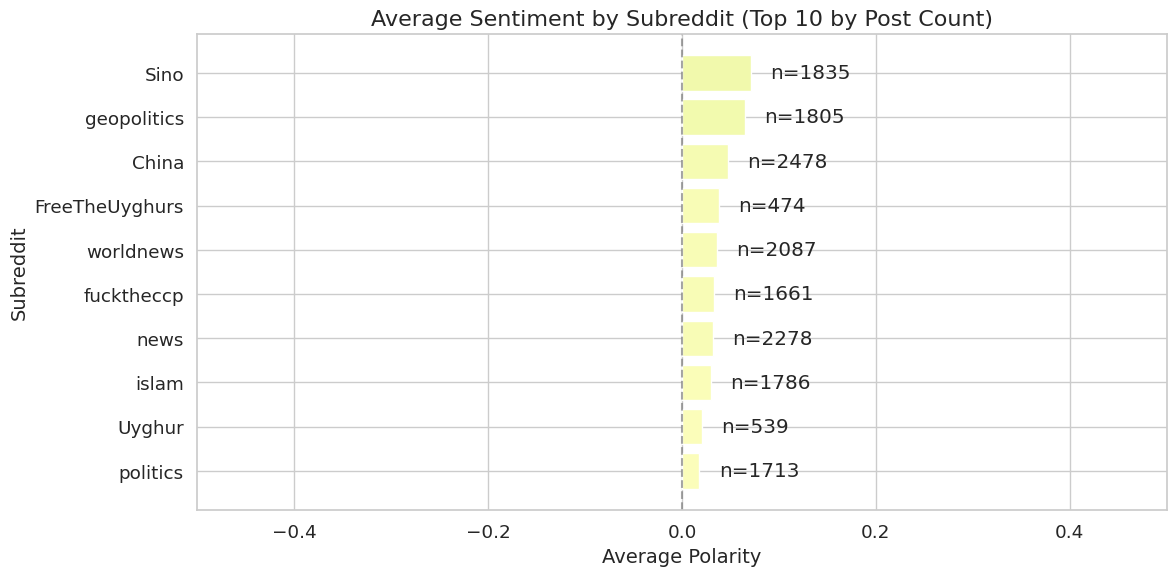

In [81]:
# Function to get sentiment using TextBlob
def get_textblob_sentiment(text):
    if pd.isna(text) or text == "":
        return None, None

    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    subjectivity = analysis.sentiment.subjectivity

    return polarity, subjectivity

# Apply sentiment analysis to the dataset (use combined_text for full context)
sentiments = reddit_data_df['combined_text'].apply(get_textblob_sentiment)
reddit_data_df['polarity'] = sentiments.apply(lambda x: x[0] if x else None)
reddit_data_df['subjectivity'] = sentiments.apply(lambda x: x[1] if x else None)

# Add sentiment category
def categorize_sentiment(polarity):
    if pd.isna(polarity):
        return None
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

reddit_data_df['sentiment_category'] = reddit_data_df['polarity'].apply(categorize_sentiment)

# Visualize overall sentiment distribution
plt.figure(figsize=(12, 6))
sentiment_counts = reddit_data_df['sentiment_category'].value_counts()
ax = sentiment_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Overall Sentiment Distribution in Reddit Content', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)

# Add count labels
for i, v in enumerate(sentiment_counts):
    ax.text(i, v + 0.1, str(v), ha='center')

plt.tight_layout()
plt.show()

# Compare sentiment between posts and comments
plt.figure(figsize=(14, 6))
content_type_sentiment = pd.crosstab(
    reddit_data_df['is_comment'].map({True: 'Comment', False: 'Post'}),
    reddit_data_df['sentiment_category']
)
content_type_sentiment_pct = content_type_sentiment.div(content_type_sentiment.sum(axis=1), axis=0) * 100

content_type_sentiment_pct.plot(kind='bar', stacked=True, color=['red', 'gray', 'green'])
plt.title('Sentiment Distribution by Content Type', fontsize=16)
plt.xlabel('Content Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Polarity vs. Subjectivity Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=reddit_data_df,
    x='polarity',
    y='subjectivity',
    hue=reddit_data_df['is_comment'].map({True: 'Comment', False: 'Post'}),
    style='sentiment_category',
    s=100,
    alpha=0.7
)
plt.title('Polarity vs. Subjectivity by Content Type and Sentiment', fontsize=16)
plt.xlabel('Polarity (Negative to Positive)', fontsize=14)
plt.ylabel('Subjectivity (Objective to Subjective)', fontsize=14)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Average sentiment by subreddit (top 10)
subreddit_sentiment = reddit_data_df.groupby('subreddit')['polarity'].agg(['mean', 'count']).sort_values('count', ascending=False).head(10)
subreddit_sentiment = subreddit_sentiment.sort_values('mean')

plt.figure(figsize=(12, 6))
bars = plt.barh(subreddit_sentiment.index, subreddit_sentiment['mean'], color=plt.cm.RdYlGn(0.5 + subreddit_sentiment['mean']/2))
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
plt.title('Average Sentiment by Subreddit (Top 10 by Post Count)', fontsize=16)
plt.xlabel('Average Polarity', fontsize=14)
plt.ylabel('Subreddit', fontsize=14)
plt.xlim(-0.5, 0.5)  # Set x-limit for better visualization
# Add count annotations
for i, (idx, row) in enumerate(subreddit_sentiment.iterrows()):
    plt.text(row['mean'] + 0.02 if row['mean'] >= 0 else row['mean'] - 0.12,
             i,
             f"n={int(row['count'])}",
             va='center')
plt.tight_layout()
plt.show()

Device set to use cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

Sentiment analysis agreement between TextBlob and Transformer model: 26.00%


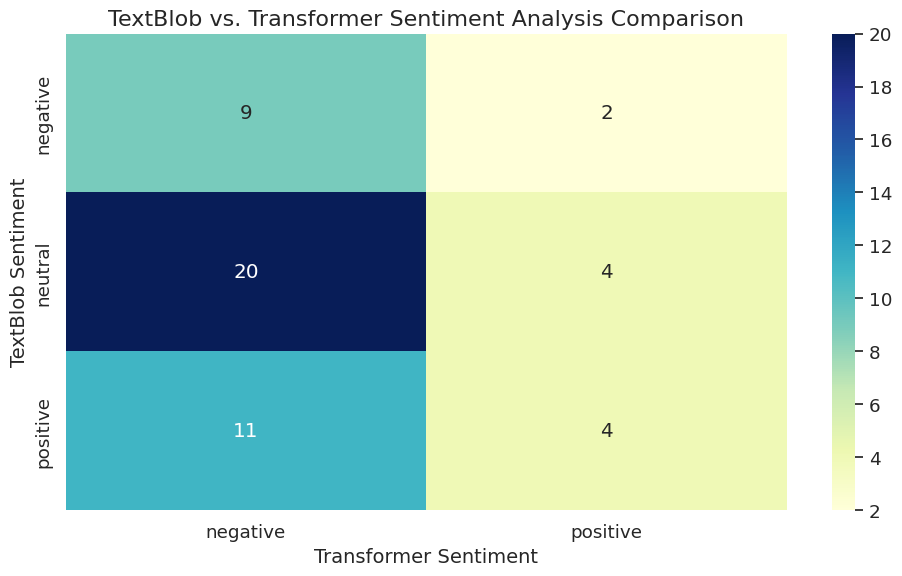

In [82]:
# Advanced Sentiment Analysis with Transformer Model
# Using a pre-trained transformer model for more accurate sentiment analysis
# This model is better at understanding context in complex sentences

# Initialize the sentiment analysis pipeline from Hugging Face
sentiment_analyzer = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to get sentiment using transformer model
def get_transformer_sentiment(text, max_length=512):
    if pd.isna(text) or text == "":
        return None, None

    # Truncate text if necessary (transformer models have max token limits)
    if len(text) > max_length:
        text = text[:max_length]

    try:
        result = sentiment_analyzer(text)[0]
        label = result['label']
        score = result['score']

        # Convert label to consistent format
        if label == 'POSITIVE':
            sentiment = 'positive'
            polarity = score
        elif label == 'NEGATIVE':
            sentiment = 'negative'
            polarity = -score
        else:
            sentiment = 'neutral'
            polarity = 0

        return sentiment, polarity
    except Exception as e:
        print(f"Error analyzing text: {e}")
        return None, None

# Apply transformer-based sentiment analysis to a sample of the dataset
# (Using a sample to speed up execution - remove sampling for full analysis)
sample_size = min(len(reddit_data_df), 50)  # Analyze 50 items
sample_df = reddit_data_df.sample(sample_size, random_state=42)

# Get transformer sentiment for the sample
transformer_sentiments = []
for text in tqdm(sample_df['combined_text']):
    sentiment, polarity = get_transformer_sentiment(text)
    transformer_sentiments.append((sentiment, polarity))

sample_df['transformer_sentiment'] = [s[0] for s in transformer_sentiments]
sample_df['transformer_polarity'] = [s[1] for s in transformer_sentiments]

# Compare TextBlob and Transformer sentiments
comparison_df = sample_df[['combined_text', 'sentiment_category', 'transformer_sentiment']].copy()
comparison_df.rename(columns={'sentiment_category': 'textblob_sentiment'}, inplace=True)

# Calculate agreement percentage
agreement = (comparison_df['textblob_sentiment'] == comparison_df['transformer_sentiment']).mean() * 100
print(f"Sentiment analysis agreement between TextBlob and Transformer model: {agreement:.2f}%")

# Display the first few rows of the comparison
comparison_df.head()

# Visualize the comparison
plt.figure(figsize=(10, 6))
comparison = pd.crosstab(comparison_df['textblob_sentiment'], comparison_df['transformer_sentiment'])
sns.heatmap(comparison, annot=True, cmap='YlGnBu', fmt='d')
plt.title('TextBlob vs. Transformer Sentiment Analysis Comparison', fontsize=16)
plt.xlabel('Transformer Sentiment', fontsize=14)
plt.ylabel('TextBlob Sentiment', fontsize=14)
plt.tight_layout()
plt.show()

<Figure size 1600x1000 with 0 Axes>

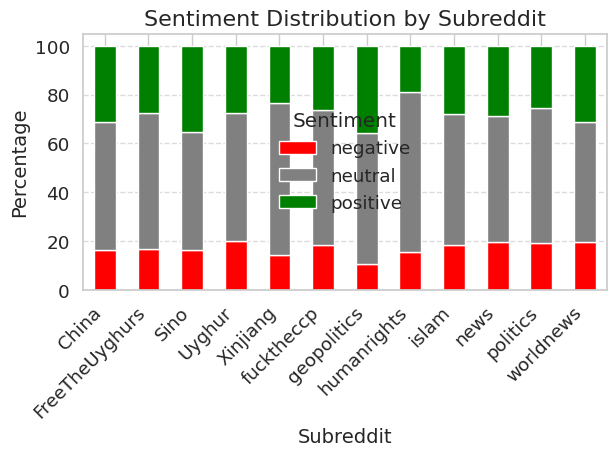

Sentiment counts by subreddit:
sentiment_category  negative  neutral  positive
subreddit                                      
China                    409     1294       775
FreeTheUyghurs            79      264       131
Sino                     297      888       650
Uyghur                   107      283       149
Xinjiang                  21       92        35
fucktheccp               304      919       438
geopolitics              190      970       645
humanrights               25      107        31
islam                    326      964       496
news                     445     1181       652
politics                 331      943       439
worldnews                411     1022       654


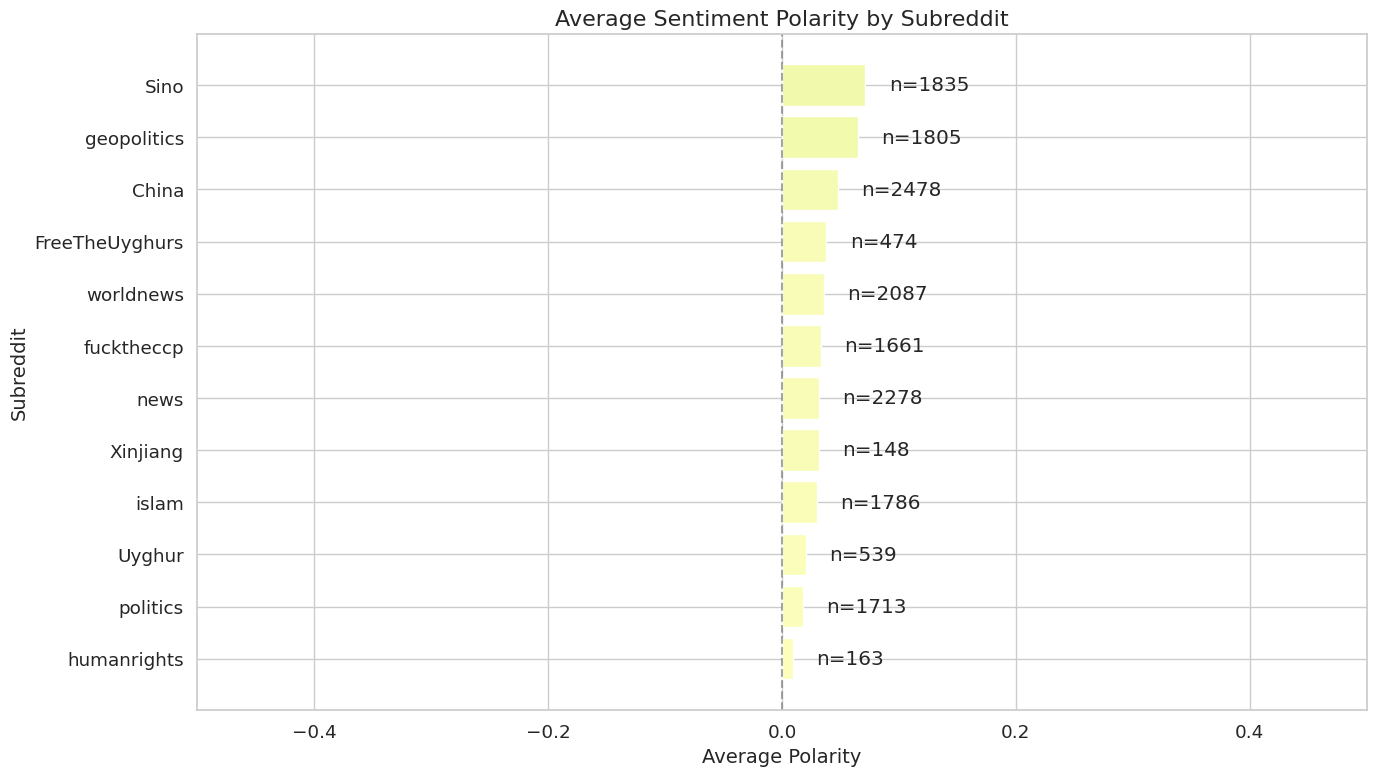

In [83]:
# Sentiment Analysis by Subreddit
# Group sentiment by subreddit
subreddit_sentiment = pd.crosstab(reddit_data_df['subreddit'], reddit_data_df['sentiment_category'])

# Filter to include only subreddits with sufficient data
min_entries = 5  # Minimum entries to include a subreddit
subreddit_sentiment = subreddit_sentiment[subreddit_sentiment.sum(axis=1) >= min_entries]

# Calculate percentages
subreddit_sentiment_pct = subreddit_sentiment.div(subreddit_sentiment.sum(axis=1), axis=0) * 100

# Plot sentiment distribution by subreddit
plt.figure(figsize=(16, 10))
subreddit_sentiment_pct.plot(kind='bar', stacked=True, color=['red', 'gray', 'green'])
plt.title('Sentiment Distribution by Subreddit', fontsize=16)
plt.xlabel('Subreddit', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Show absolute counts
print("Sentiment counts by subreddit:")
print(subreddit_sentiment)

# Visualize average polarity by subreddit
subreddit_avg_polarity = reddit_data_df.groupby('subreddit')['polarity'].mean().sort_values()
subreddit_counts = reddit_data_df['subreddit'].value_counts()

# Filter for subreddits with at least 5 entries
significant_subreddits = subreddit_counts[subreddit_counts >= min_entries].index
subreddit_avg_polarity = subreddit_avg_polarity[subreddit_avg_polarity.index.isin(significant_subreddits)]

plt.figure(figsize=(14, 8))
bars = plt.barh(subreddit_avg_polarity.index, subreddit_avg_polarity,
               color=plt.cm.RdYlGn(0.5 + subreddit_avg_polarity/2))
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
plt.title('Average Sentiment Polarity by Subreddit', fontsize=16)
plt.xlabel('Average Polarity', fontsize=14)
plt.ylabel('Subreddit', fontsize=14)
plt.xlim(-0.5, 0.5)  # Limit the x-axis for better visualization

# Add count annotations
for i, subreddit in enumerate(subreddit_avg_polarity.index):
    count = subreddit_counts[subreddit]
    plt.text(
        subreddit_avg_polarity[subreddit] + 0.02 if subreddit_avg_polarity[subreddit] >= 0
        else subreddit_avg_polarity[subreddit] - 0.1,
        i,
        f"n={count}",
        va='center'
    )

plt.tight_layout()
plt.show()


LDA Topics with Descriptive Labels:
Political and Religious Context:
another, free, allah, may, party, china, tibet, chinese, video, communist
International Relations and Politics:
china, ccp, country, fuck, would, trump, people, america, war, really
Casual Discussion and Opinions:
like, lol, know, people, look, good, didnt, never, dont, theyre
Core Uyghur Crisis Discussion:
china, nan, xinjiang, genocide, uighur, uyghur, camp, chinese, right, muslim
Meta-Discussion and Moderation:
please, question, bot, concern, comment, action, rule, let, contact, pooh

LDA Topics:
Topic #1:
another, free, allah, may, party, china, tibet, chinese, video, communist
Topic #2:
china, ccp, country, fuck, would, trump, people, america, war, really
Topic #3:
like, lol, know, people, look, good, didnt, never, dont, theyre
Topic #4:
china, nan, xinjiang, genocide, uighur, uyghur, camp, chinese, right, muslim
Topic #5:
please, question, bot, concern, comment, action, rule, let, contact, pooh


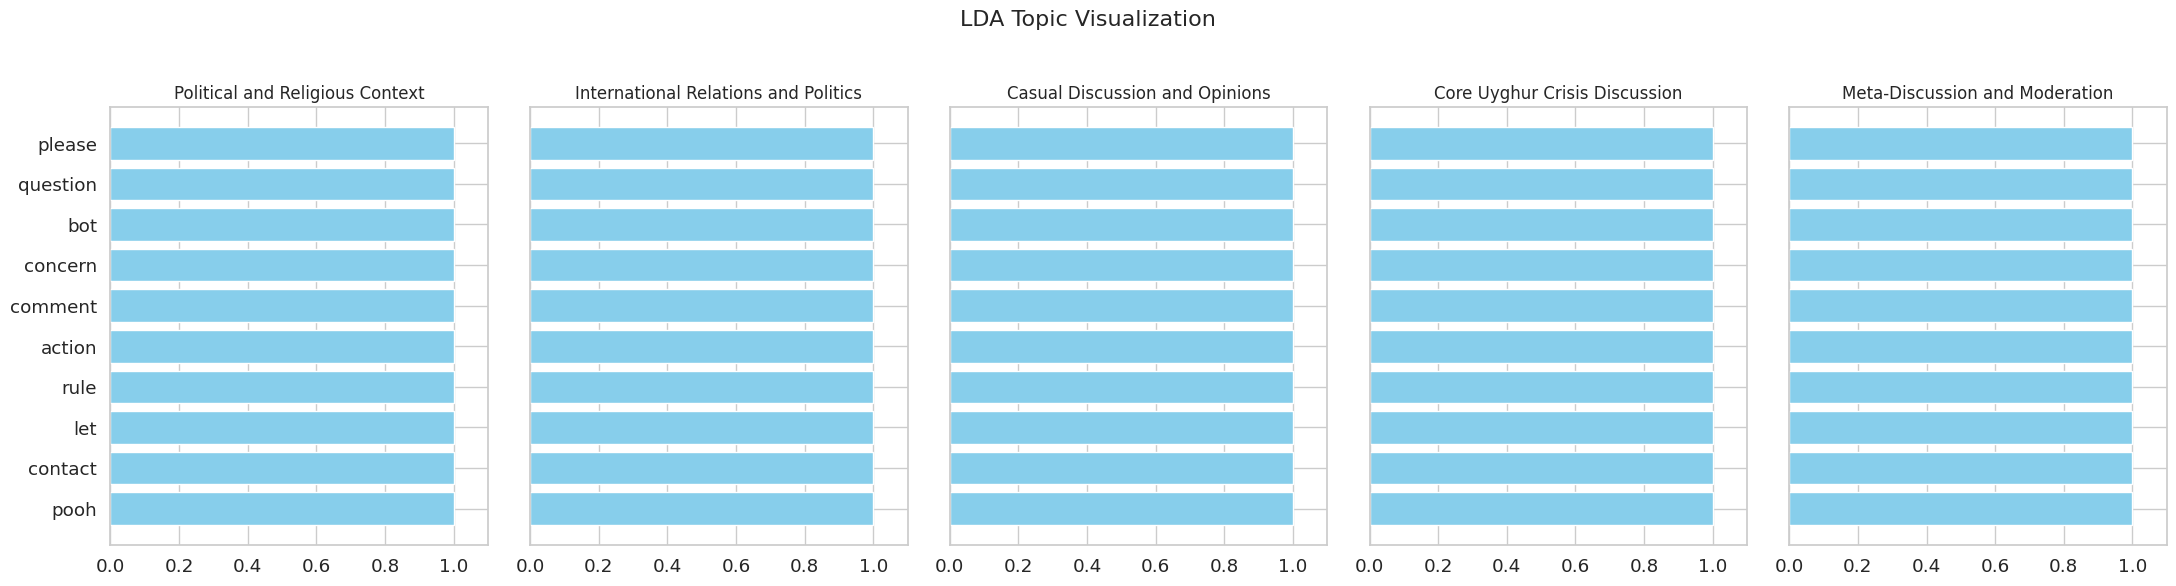

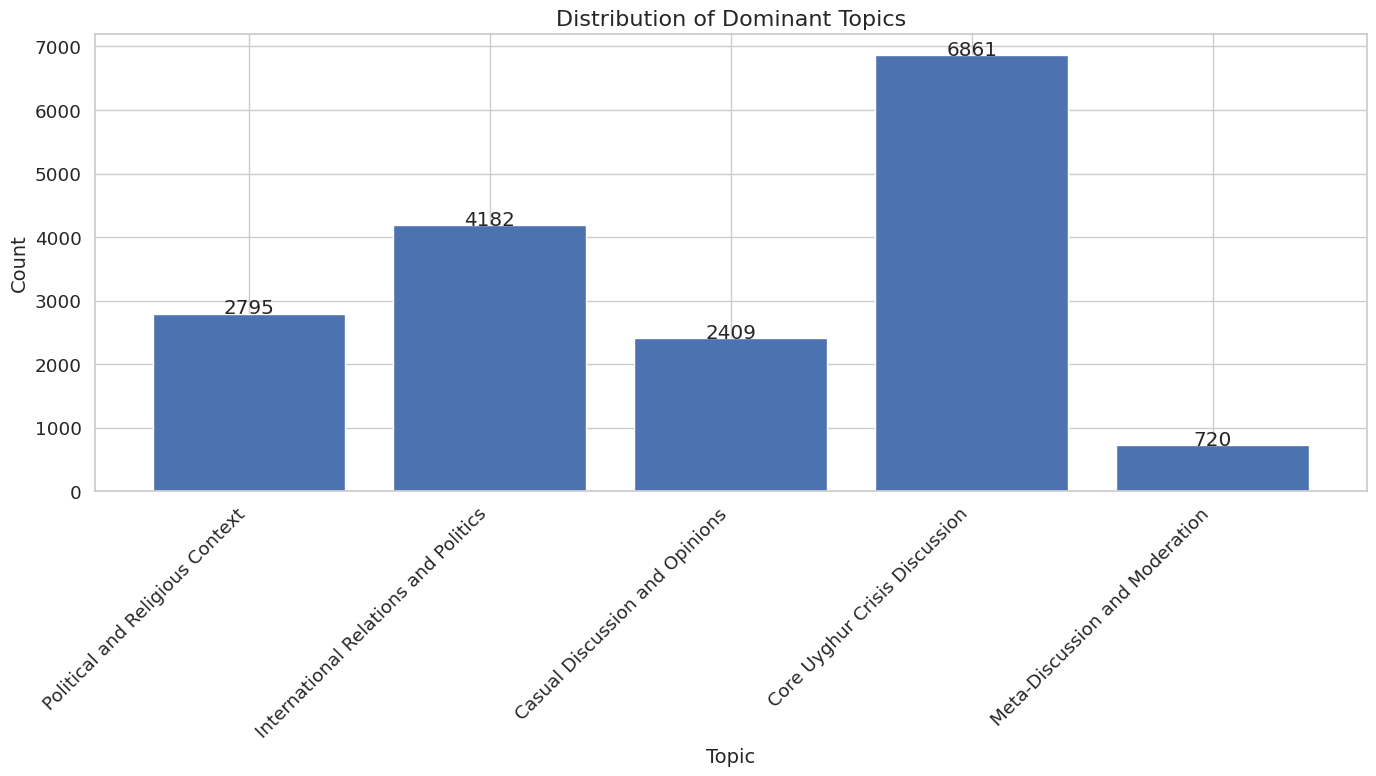

<Figure size 1400x800 with 0 Axes>

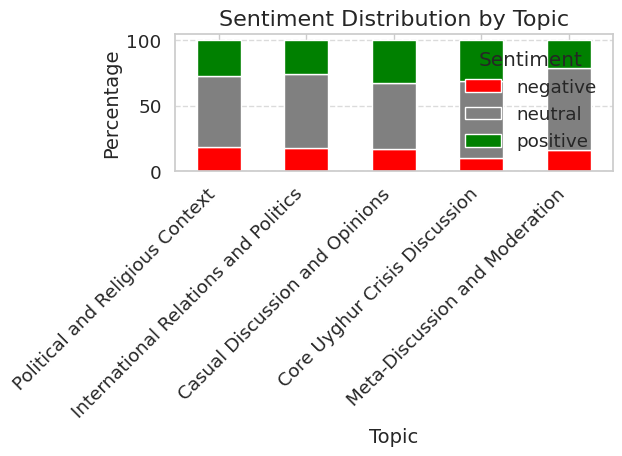

In [85]:
# Topic Modeling with LDA
# Prepare corpus for topic modeling
# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(reddit_data_df['processed_content'].fillna(''))
feature_names = tfidf_vectorizer.get_feature_names_out()

# Define descriptive topic labels
topic_labels = {
    1: "Political and Religious Context",
    2: "International Relations and Politics",
    3: "Casual Discussion and Opinions",
    4: "Core Uyghur Crisis Discussion",
    5: "Meta-Discussion and Moderation"
}

# Function to print top words for each topic with descriptive labels
def print_top_words_with_labels(model, feature_names, n_top_words, topic_labels):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(top_words)
        label = topic_labels.get(topic_idx + 1, f"Topic #{topic_idx + 1}")
        print(f"{label}:")
        print(", ".join(top_words))
    return topics

# Apply to LDA results
print("\nLDA Topics with Descriptive Labels:")
lda_topics = print_top_words_with_labels(lda, feature_names, 10, topic_labels)

# Apply LDA
n_topics = 5  # Adjust based on your needs and data size
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42,
                               max_iter=10, learning_method='online')
lda.fit(tfidf)

# Print top words for each topic
print("\nLDA Topics:")
lda_topics = print_top_words(lda, feature_names, 10)

# Modify the topic visualization function to use descriptive labels
def visualize_topics_with_labels(topics, model_name, topic_labels):
    fig, axes = plt.subplots(1, len(topics), figsize=(22, 6), sharey=True)

    for i, (topic, ax) in enumerate(zip(topics, axes)):
        ax.barh(range(len(topic)), [1] * len(topic), align='center', color='skyblue')
        ax.set_yticks(range(len(topic)))
        ax.set_yticklabels(topic)
        ax.invert_yaxis()
        label = topic_labels.get(i + 1, f"Topic {i+1}")
        ax.set_title(label, fontsize=12)
        ax.set_xlim(0, 1.1)

    plt.suptitle(f'{model_name} Topic Visualization', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Visualize LDA topics with descriptive labels
visualize_topics_with_labels(lda_topics, "LDA", topic_labels)

# Get the topic distribution for each document
doc_topics = lda.transform(tfidf)

# Assign the dominant topic to each document
reddit_data_df['dominant_topic'] = doc_topics.argmax(axis=1) + 1  # Add 1 for 1-based indexing

# Update topic distribution chart with descriptive labels
plt.figure(figsize=(14, 8))
topic_counts = reddit_data_df['dominant_topic'].value_counts().sort_index()

# Create better x-axis labels
x_labels = [topic_labels.get(i, f"Topic {i}") for i in topic_counts.index]

# Plot with better labels
ax = plt.bar(range(len(topic_counts)), topic_counts.values)
plt.xticks(range(len(topic_counts)), x_labels, rotation=45, ha='right')
plt.title('Distribution of Dominant Topics', fontsize=16)
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add count labels on top of bars
for i, v in enumerate(topic_counts.values):
    plt.text(i, v + 0.1, str(v), ha='center')

plt.tight_layout()
plt.show()

# Update the sentiment by topic chart
topic_sentiment_pct = topic_sentiment.div(topic_sentiment.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
topic_sentiment_pct.plot(kind='bar', stacked=True, color=['red', 'gray', 'green'])

# Replace x-axis labels with descriptive topic names
plt.xticks(range(len(topic_labels)), [topic_labels.get(i, f"Topic {i}") for i in range(1, len(topic_labels)+1)], rotation=45, ha='right')

plt.title('Sentiment Distribution by Topic', fontsize=16)
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Sentiment')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


NMF Topics:
Political and Religious Context:
people, like, chinese, country, dont, muslim, would, one, even, think
International Relations and Politics:
nan, xinjiang, uighur, uyghur, camp, chinese, uyghurs, forced, muslim, labor
Casual Discussion and Opinions:
please, question, bot, moderator, contact, automatically, performed, concern, action, rule
Core Uyghur Crisis Discussion:
china, fuck, world, country, taiwan, un, war, uyghurs, state, part
Meta-Discussion and Moderation:
genocide, uyghur, cultural, israel, committing, call, group, evidence, stop, committed


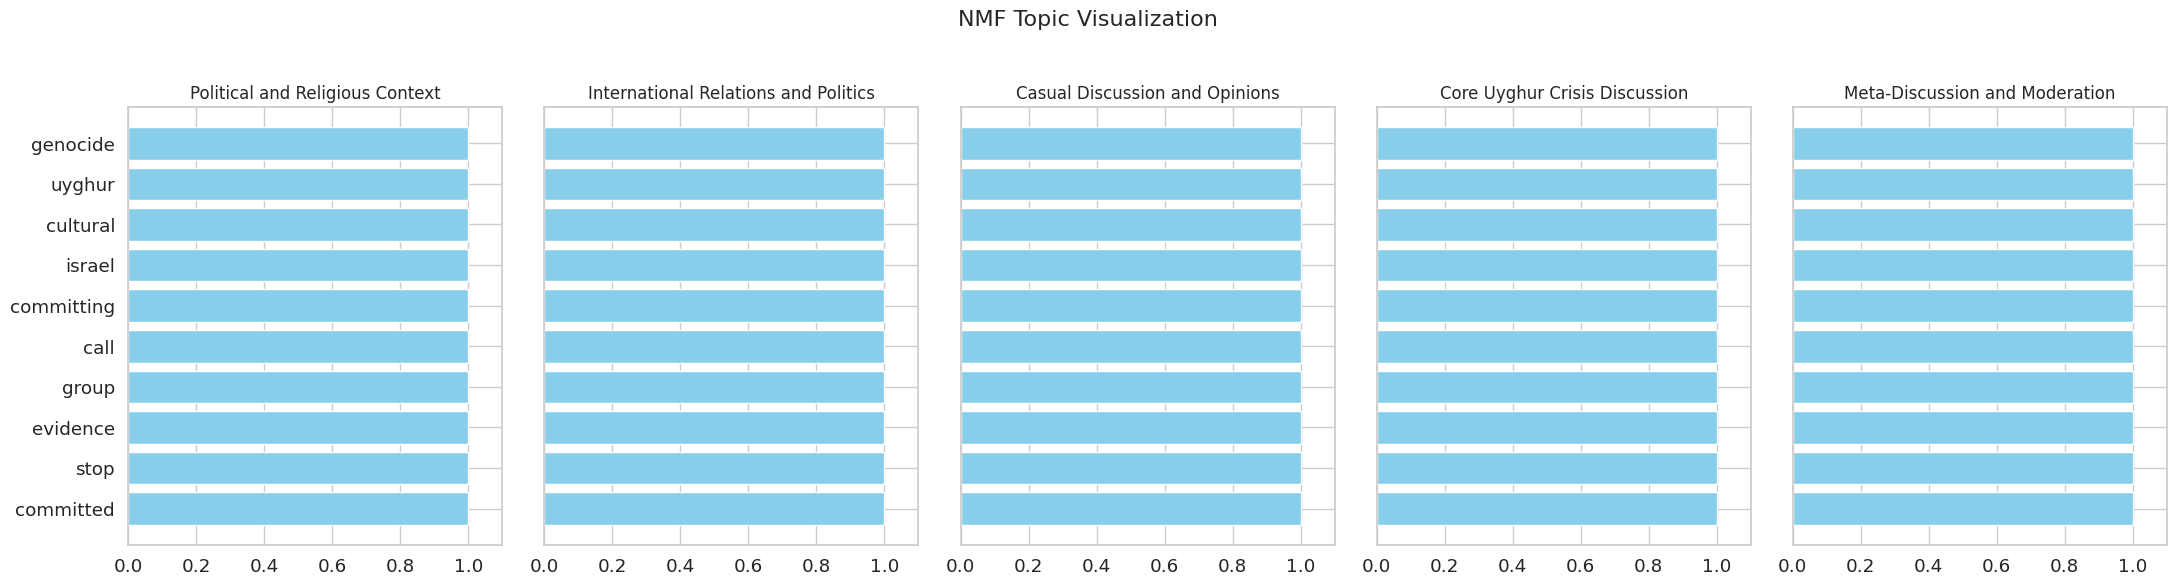

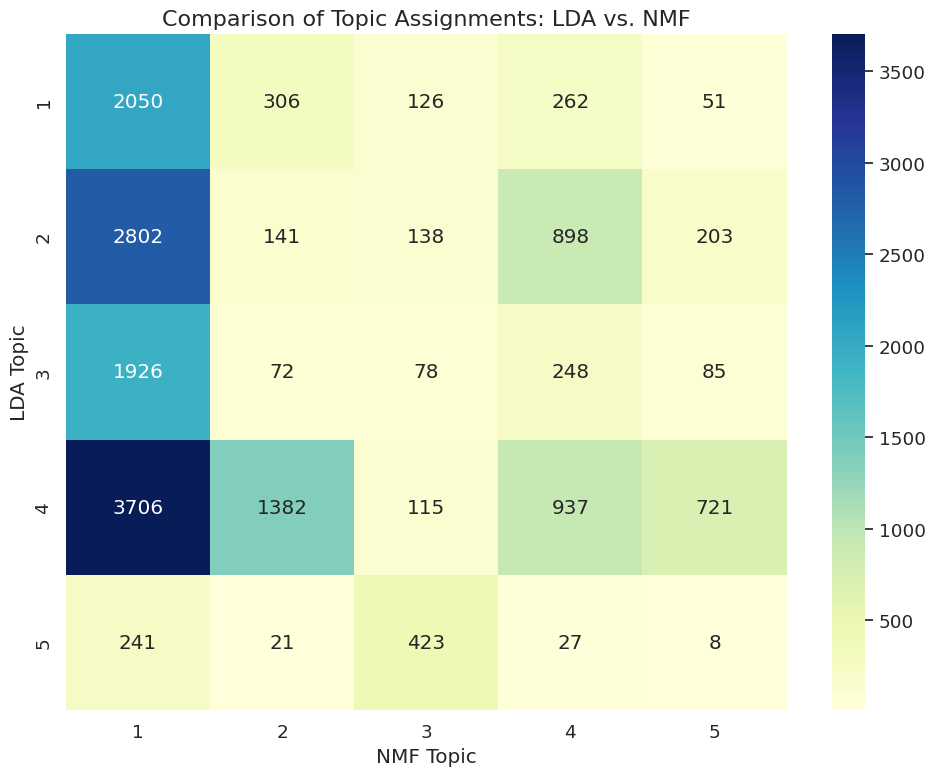

<Figure size 1400x800 with 0 Axes>

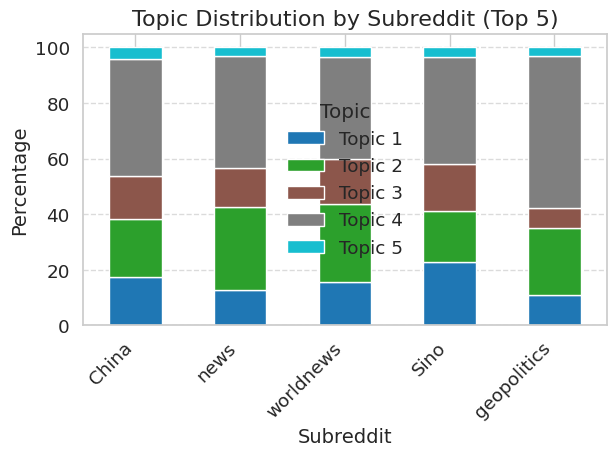

In [88]:
# Topic Modeling with NMF
# Apply NMF for comparison
nmf = NMF(n_components=n_topics, random_state=42)
nmf.fit(tfidf)

# Print top words for NMF topics
print("\nNMF Topics:")
nmf_topics = print_top_words_with_labels(nmf, feature_names, 10, topic_labels)

# Visualize NMF topics
visualize_topics_with_labels(nmf_topics, "NMF", topic_labels)

# Get the topic distribution for each document
doc_nmf_topics = nmf.transform(tfidf)

# Assign the dominant NMF topic to each document
reddit_data_df['dominant_nmf_topic'] = doc_nmf_topics.argmax(axis=1) + 1  # Add 1 for 1-based indexing

# Compare LDA and NMF topic assignments
topic_comparison = pd.crosstab(reddit_data_df['dominant_topic'], reddit_data_df['dominant_nmf_topic'])
topic_comparison.index.name = 'LDA Topic'
topic_comparison.columns.name = 'NMF Topic'

plt.figure(figsize=(10, 8))
sns.heatmap(topic_comparison, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Comparison of Topic Assignments: LDA vs. NMF', fontsize=16)
plt.tight_layout()
plt.show()

# Topic distribution by subreddit (top 5 subreddits only)
top_5_subreddits = reddit_data_df['subreddit'].value_counts().head(5).index
subreddit_topics = pd.crosstab(
    reddit_data_df['subreddit'],
    reddit_data_df['dominant_topic']
)
subreddit_topics = subreddit_topics.loc[top_5_subreddits]
subreddit_topics_pct = subreddit_topics.div(subreddit_topics.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
subreddit_topics_pct.plot(kind='bar', stacked=True, colormap='tab10')
plt.title('Topic Distribution by Subreddit (Top 5)', fontsize=16)
plt.xlabel('Subreddit', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Topic', labels=[f'Topic {i}' for i in range(1, n_topics+1)])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

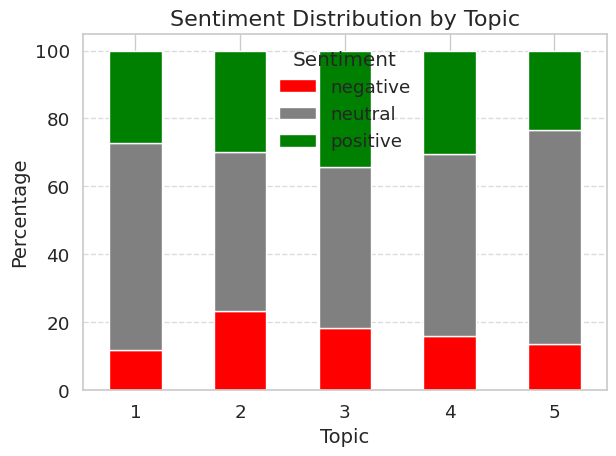

Sentiment counts by topic:
sentiment_category  negative  neutral  positive
dominant_topic                                 
1                        329     1703       763
2                        979     1951      1252
3                        439     1146       824
4                       1099     3675      2087
5                         99      452       169


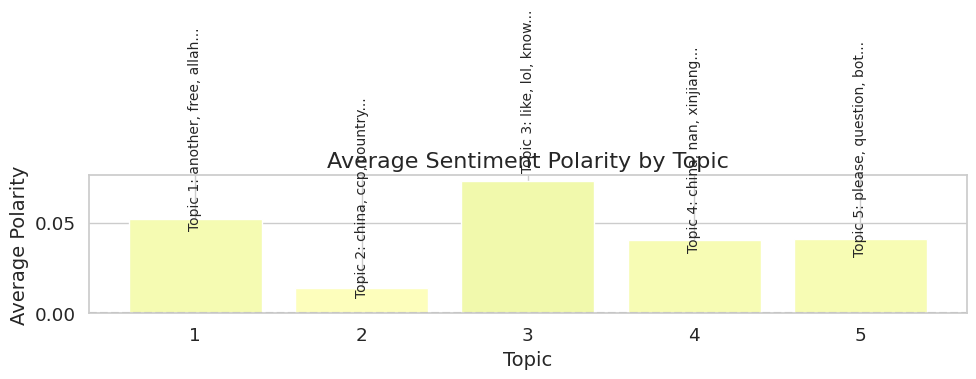

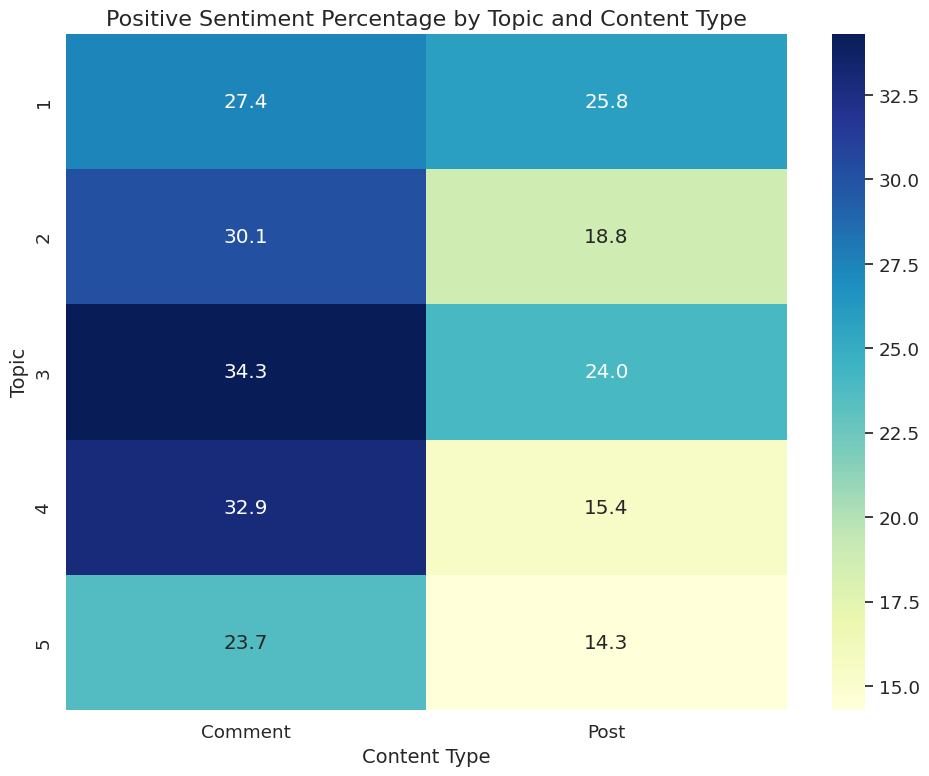

In [91]:
# Relationship Between Topics and Sentiment
# Analyze the relationship between topics and sentiment
topic_sentiment = pd.crosstab(reddit_data_df['dominant_topic'], reddit_data_df['sentiment_category'])
topic_sentiment_pct = topic_sentiment.div(topic_sentiment.sum(axis=1), axis=0) * 100

# Visualize sentiment distribution by topic
plt.figure(figsize=(12, 8))
topic_sentiment_pct.plot(kind='bar', stacked=True, color=['red', 'gray', 'green'])
plt.title('Sentiment Distribution by Topic', fontsize=16)
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Show absolute counts
print("Sentiment counts by topic:")
print(topic_sentiment)

# Calculate average sentiment polarity by topic
topic_polarity = reddit_data_df.groupby('dominant_topic')['polarity'].mean()

plt.figure(figsize=(10, 6))
bars = plt.bar(topic_polarity.index, topic_polarity, color=plt.cm.RdYlGn(0.5 + topic_polarity/2))
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.title('Average Sentiment Polarity by Topic', fontsize=16)
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Average Polarity', fontsize=14)
plt.xticks(topic_polarity.index)

# Add topic keywords as text annotations
for i, topic_words in enumerate(lda_topics):
    topic_label = ', '.join(topic_words[:3])  # First 3 words of each topic
    plt.annotate(f"Topic {i+1}: {topic_label}...",
                 xy=(i+1, topic_polarity[i+1]),
                 xytext=(i+1, topic_polarity[i+1] + (0.05 if topic_polarity[i+1] >= 0 else -0.05)),
                 ha='center', va='center', rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

# Create a heatmap of sentiment by topic and content type
sentiment_topic_type = pd.crosstab(
    [reddit_data_df['dominant_topic'], reddit_data_df['is_comment'].map({True: 'Comment', False: 'Post'})],
    reddit_data_df['sentiment_category']
)
sentiment_topic_type_pct = sentiment_topic_type.div(sentiment_topic_type.sum(axis=1), axis=0) * 100

# Display positive sentiment percentage as a heatmap
if 'positive' in sentiment_topic_type_pct.columns:
    positive_sentiment = sentiment_topic_type_pct['positive'].unstack()

    plt.figure(figsize=(10, 8))
    sns.heatmap(positive_sentiment, annot=True, cmap='YlGnBu', fmt='.1f')
    plt.title('Positive Sentiment Percentage by Topic and Content Type', fontsize=16)
    plt.xlabel('Content Type', fontsize=14)
    plt.ylabel('Topic', fontsize=14)
    plt.tight_layout()
    plt.show()

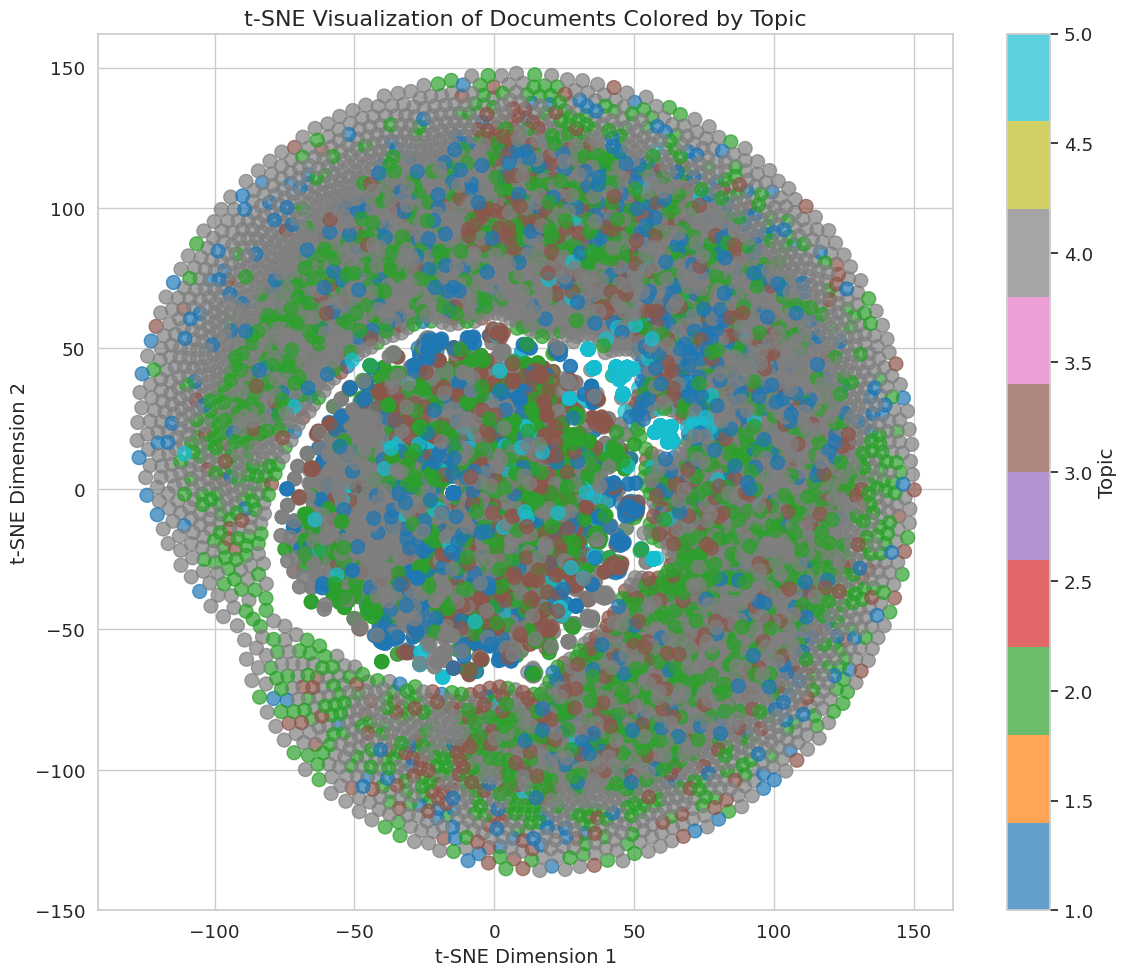

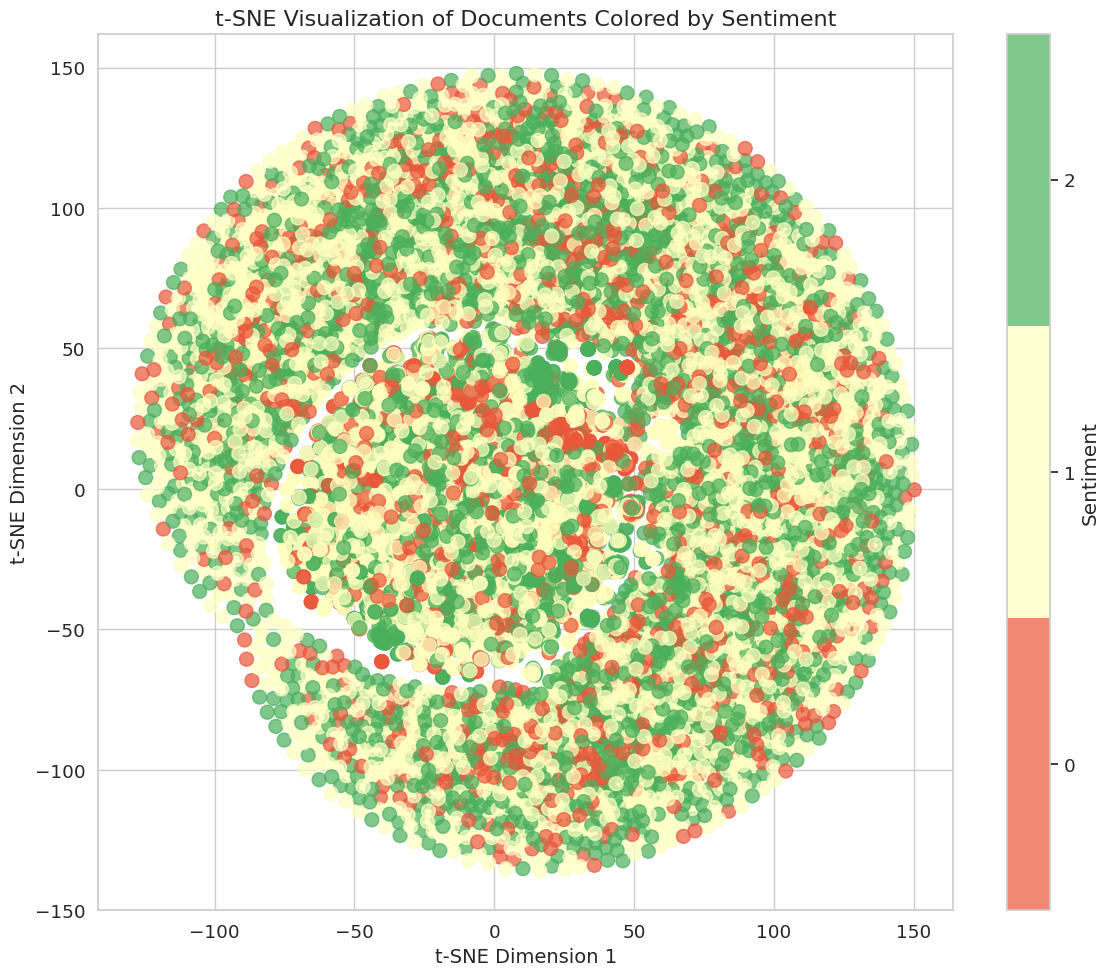

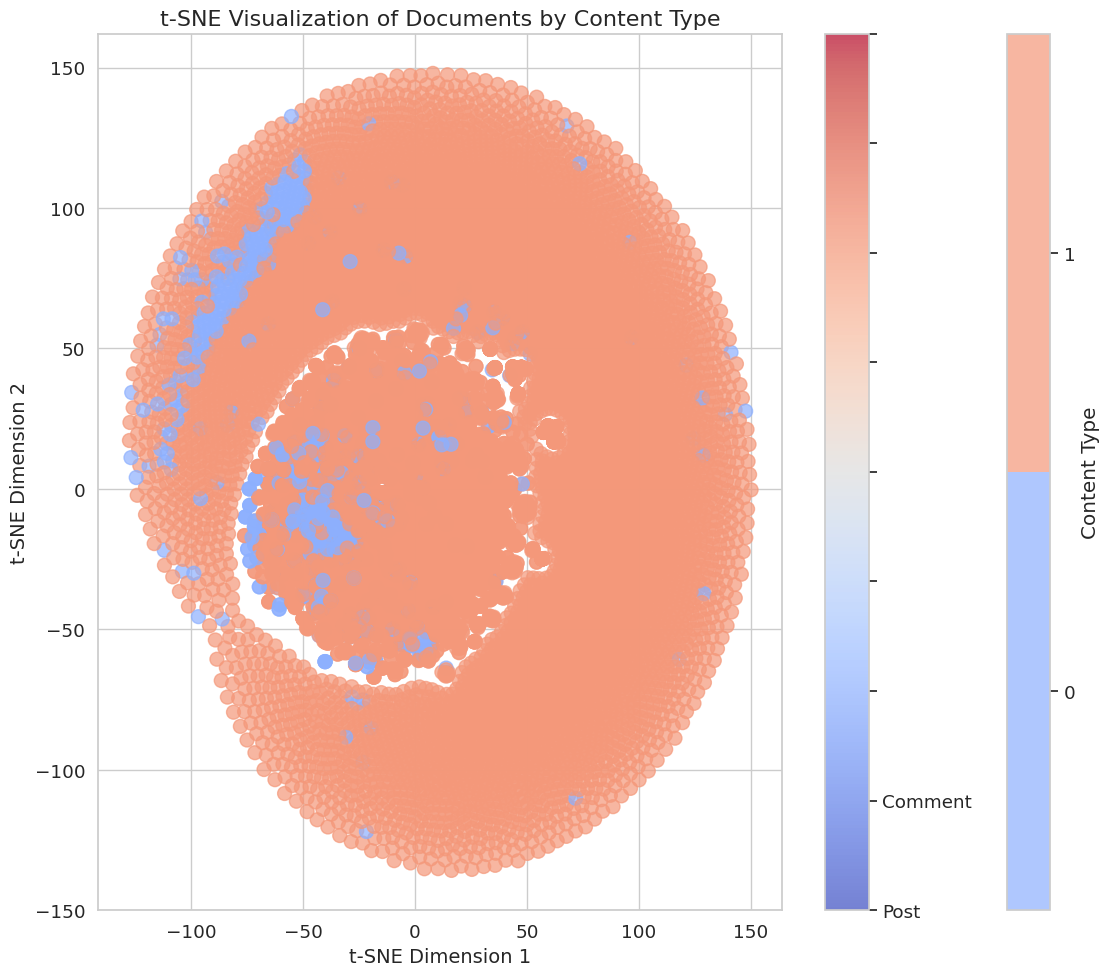

In [92]:
# Dimensionality Reduction and Clustering
# Use t-SNE to visualize document clustering
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(tfidf.toarray())

# Add t-SNE results to the DataFrame
reddit_data_df['tsne_x'] = tsne_results[:, 0]
reddit_data_df['tsne_y'] = tsne_results[:, 1]

# Visualize documents colored by dominant topic
plt.figure(figsize=(12, 10))
scatter = plt.scatter(reddit_data_df['tsne_x'], reddit_data_df['tsne_y'],
                      c=reddit_data_df['dominant_topic'], cmap='tab10', alpha=0.7, s=100)
plt.colorbar(scatter, label='Topic')
plt.title('t-SNE Visualization of Documents Colored by Topic', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)
plt.tight_layout()
plt.show()

# Visualize documents colored by sentiment
# Create a numeric mapping for sentiment categories
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
reddit_data_df['sentiment_numeric'] = reddit_data_df['sentiment_category'].map(sentiment_map)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(reddit_data_df['tsne_x'], reddit_data_df['tsne_y'],
                      c=reddit_data_df['sentiment_numeric'], cmap='RdYlGn', alpha=0.7, s=100)
plt.colorbar(scatter, label='Sentiment', ticks=[0, 1, 2],
             boundaries=[-0.5, 0.5, 1.5, 2.5],
             values=[0, 1, 2])
plt.clim(-0.5, 2.5)  # Set color limits
plt.title('t-SNE Visualization of Documents Colored by Sentiment', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)
plt.tight_layout()
plt.show()

# Visualize documents colored by content type (post vs comment)
plt.figure(figsize=(12, 10))
scatter = plt.scatter(reddit_data_df['tsne_x'], reddit_data_df['tsne_y'],
                     c=reddit_data_df['is_comment'].astype(int), cmap='coolwarm', alpha=0.7, s=100)
plt.colorbar(scatter, label='Content Type', ticks=[0, 1],
            boundaries=[-0.5, 0.5, 1.5],
            values=[0, 1])
plt.clim(-0.5, 1.5)  # Set color limits
cbar = plt.colorbar()
cbar.set_ticklabels(['Post', 'Comment'])
plt.title('t-SNE Visualization of Documents by Content Type', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)
plt.tight_layout()
plt.show()

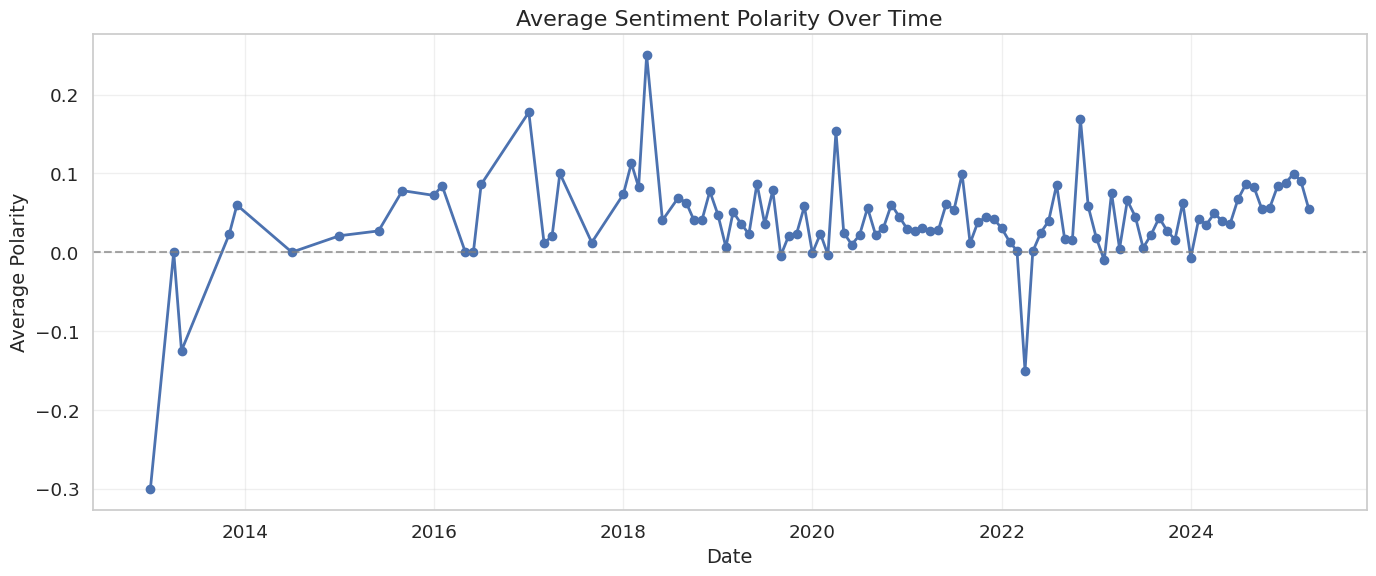

<Figure size 1400x800 with 0 Axes>

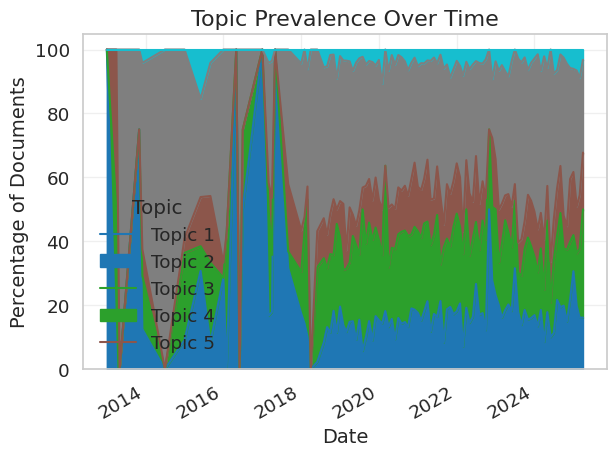

<Figure size 1400x600 with 0 Axes>

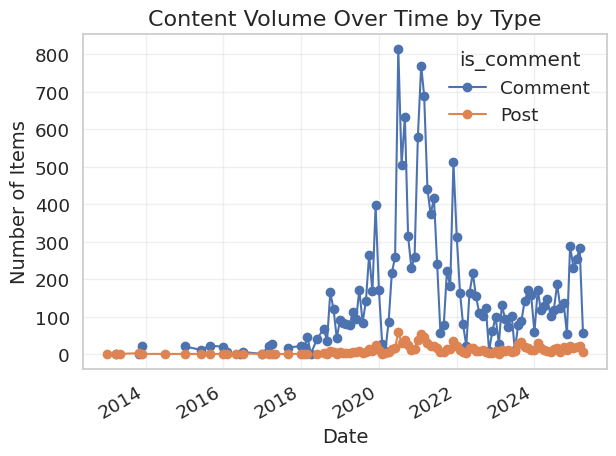

In [93]:
# Time-Based Analysis
# Analyze sentiment changes over time (if time data is available)
if 'created_at' in reddit_data_df.columns and reddit_data_df['created_at'].notna().any():
    # Ensure created_at is a datetime
    reddit_data_df['created_at'] = pd.to_datetime(reddit_data_df['created_at'])

    # Group by month and compute average sentiment
    reddit_data_df['month_year'] = reddit_data_df['created_at'].dt.strftime('%Y-%m')
    monthly_sentiment = reddit_data_df.groupby('month_year')['polarity'].mean().reset_index()
    monthly_sentiment['month_year'] = pd.to_datetime(monthly_sentiment['month_year'] + '-01')
    monthly_sentiment = monthly_sentiment.sort_values('month_year')

    # Plot sentiment trends over time
    plt.figure(figsize=(14, 6))
    plt.plot(monthly_sentiment['month_year'], monthly_sentiment['polarity'], marker='o', linewidth=2)
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    plt.title('Average Sentiment Polarity Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Average Polarity', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Topic prevalence over time
    # Count documents by topic and month
    topic_time = pd.crosstab(reddit_data_df['month_year'], reddit_data_df['dominant_topic'])
    topic_time_pct = topic_time.div(topic_time.sum(axis=1), axis=0) * 100

    # Convert index to datetime for proper ordering
    topic_time_pct.index = pd.to_datetime(topic_time_pct.index + '-01')
    topic_time_pct = topic_time_pct.sort_index()

    # Plot topic prevalence over time
    plt.figure(figsize=(14, 8))
    topic_time_pct.plot(kind='area', stacked=True, colormap='tab10')
    plt.title('Topic Prevalence Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Percentage of Documents', fontsize=14)
    plt.legend(title='Topic', labels=[f'Topic {i}' for i in range(1, n_topics+1)])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Analyze content volume over time by content type
    volume_by_month = reddit_data_df.groupby(['month_year', reddit_data_df['is_comment'].map({True: 'Comment', False: 'Post'})]).size().unstack()
    volume_by_month.index = pd.to_datetime(volume_by_month.index + '-01')
    volume_by_month = volume_by_month.sort_index()

    plt.figure(figsize=(14, 6))
    volume_by_month.plot(kind='line', marker='o')
    plt.title('Content Volume Over Time by Type', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Number of Items', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Time data not available for temporal analysis.")

<Figure size 1400x800 with 0 Axes>

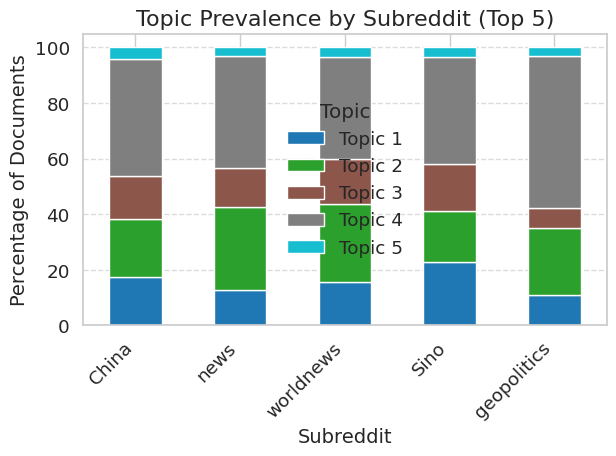


Sentiment statistics by content type:
                mean  median       std  min  max
is_comment                                      
Comment     0.043471     0.0  0.257086 -1.0  1.0
Post        0.001372     0.0  0.181321 -1.0  0.8


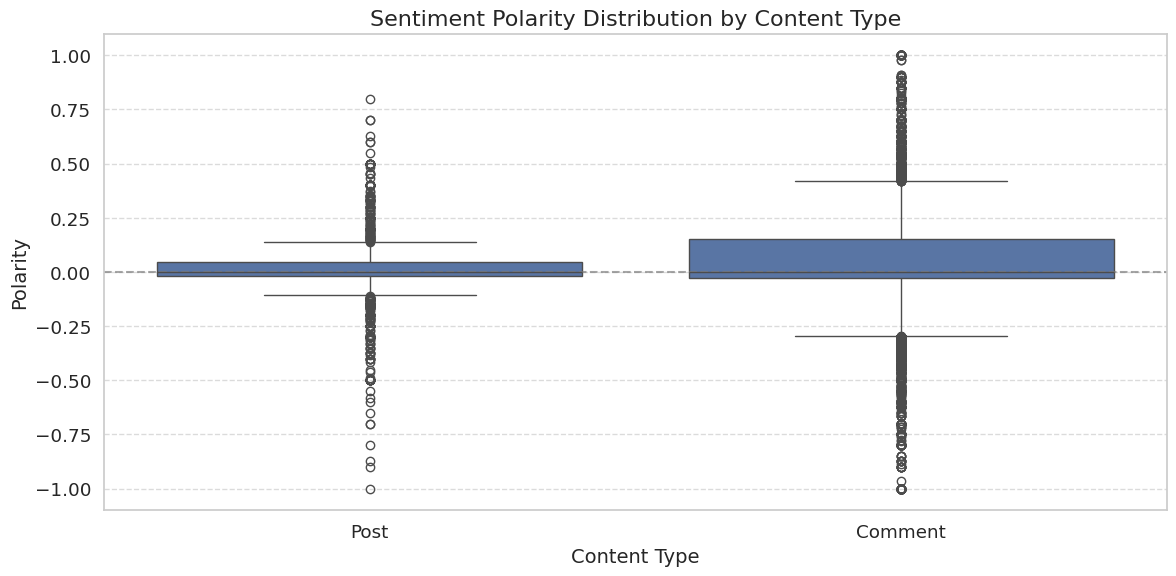


Correlation between post/comment score and sentiment polarity: -0.0152


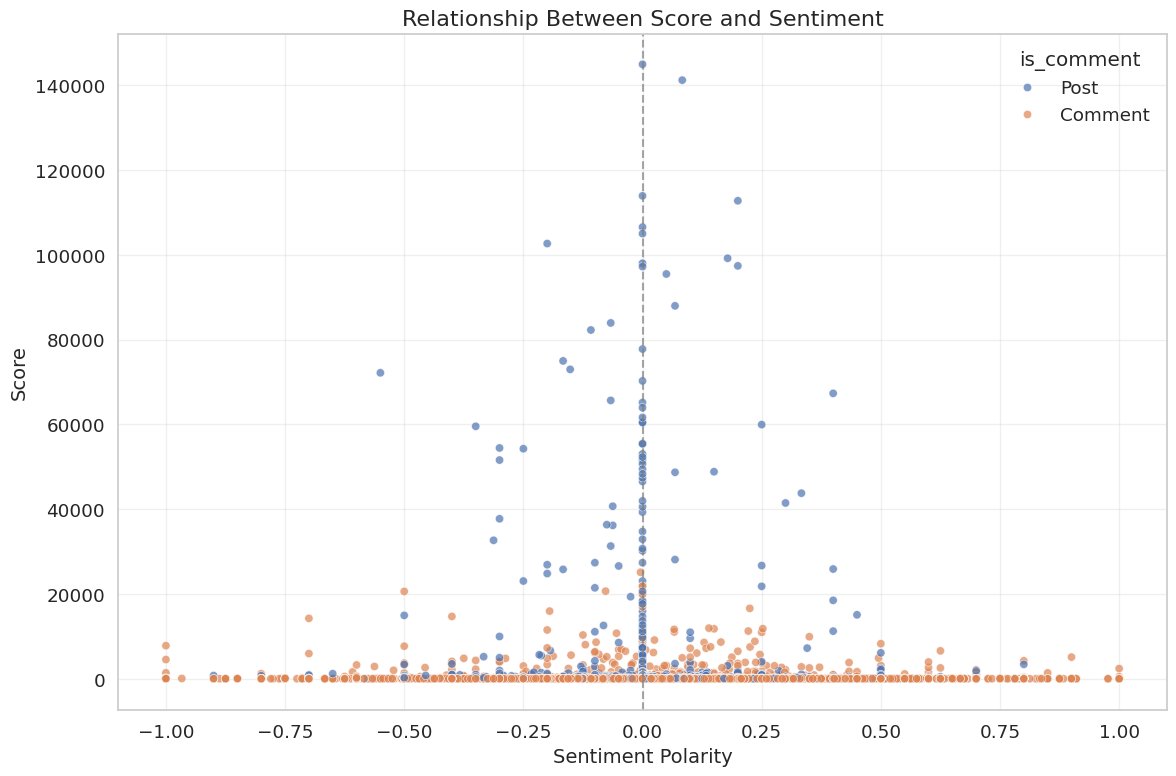

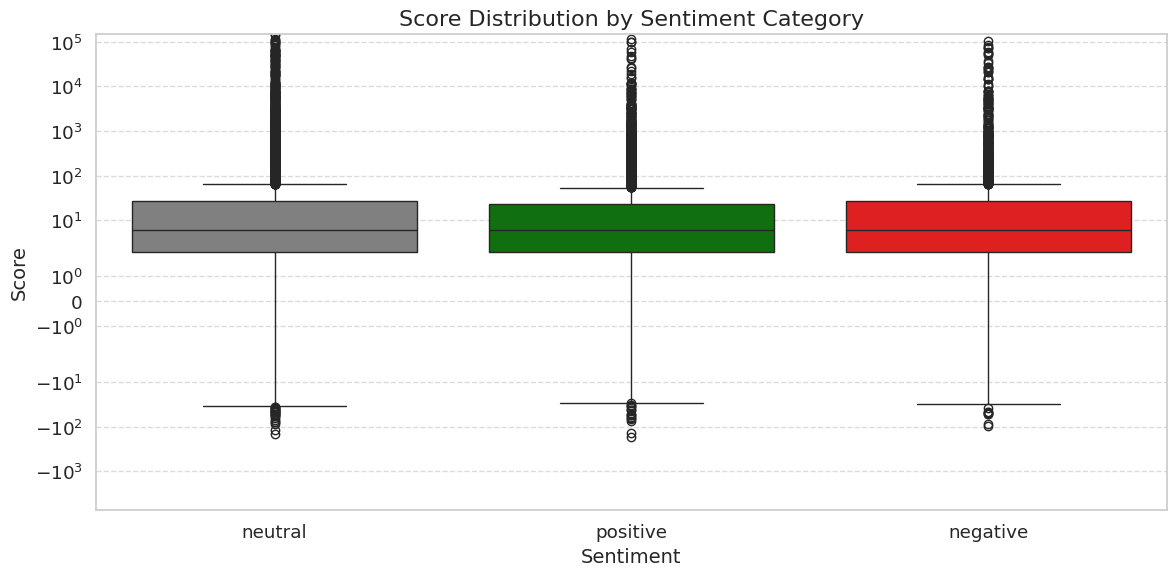

In [94]:
# Subreddit and Content Type Analysis
# Topic prevalence by subreddit (top subreddits)
top_subreddits = reddit_data_df['subreddit'].value_counts().head(5).index
subreddit_topic = pd.crosstab(
    reddit_data_df['subreddit'],
    reddit_data_df['dominant_topic']
)
subreddit_topic = subreddit_topic.loc[top_subreddits]  # Filter to top subreddits
subreddit_topic_pct = subreddit_topic.div(subreddit_topic.sum(axis=1), axis=0) * 100

# Plot topic prevalence by subreddit
plt.figure(figsize=(14, 8))
subreddit_topic_pct.plot(kind='bar', stacked=True, colormap='tab10')
plt.title('Topic Prevalence by Subreddit (Top 5)', fontsize=16)
plt.xlabel('Subreddit', fontsize=14)
plt.ylabel('Percentage of Documents', fontsize=14)
plt.legend(title='Topic', labels=[f'Topic {i}' for i in range(1, n_topics+1)])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Compare sentiment statistics by content type
sentiment_stats = reddit_data_df.groupby(
    reddit_data_df['is_comment'].map({True: 'Comment', False: 'Post'})
)['polarity'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nSentiment statistics by content type:")
print(sentiment_stats)

# Visualize sentiment distribution by content type with box plots
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=reddit_data_df,
    x=reddit_data_df['is_comment'].map({True: 'Comment', False: 'Post'}),
    y='polarity'
)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.title('Sentiment Polarity Distribution by Content Type', fontsize=16)
plt.xlabel('Content Type', fontsize=14)
plt.ylabel('Polarity', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Analysis of post scores and sentiment
if 'score' in reddit_data_df.columns:
    # Correlation between post score and sentiment
    post_score_sentiment_corr = reddit_data_df['score'].corr(reddit_data_df['polarity'])
    print(f"\nCorrelation between post/comment score and sentiment polarity: {post_score_sentiment_corr:.4f}")

    # Visualize relationship between score and sentiment
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=reddit_data_df,
        x='polarity',
        y='score',
        hue=reddit_data_df['is_comment'].map({True: 'Comment', False: 'Post'}),
        alpha=0.7
    )
    plt.title('Relationship Between Score and Sentiment', fontsize=16)
    plt.xlabel('Sentiment Polarity', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Box plot of scores by sentiment category
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=reddit_data_df,
        x='sentiment_category',
        y='score',
        palette={'negative': 'red', 'neutral': 'gray', 'positive': 'green'}
    )
    plt.title('Score Distribution by Sentiment Category', fontsize=16)
    plt.xlabel('Sentiment', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.yscale('symlog')  # Use symlog scale to handle potential outliers
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Overall Sentiment Distribution:
sentiment_category
neutral     52.613898
positive    30.028880
negative    17.357223
Name: proportion, dtype: float64

Top 20 Most Common Words:
          Word  Count
0        china   7679
1       people   3346
2      chinese   3141
3            u   2658
4         like   2466
5     xinjiang   2266
6      country   2230
7       muslim   2155
8          one   2007
9        would   1955
10        dont   1833
11       right   1683
12    genocide   1666
13       world   1519
14        even   1494
15        also   1395
16      uyghur   1378
17      uighur   1374
18  government   1347
19       think   1255

Identified Topics:
Topic 1: another, free, allah, may, party, china, tibet, chinese, video, communist
Topic 2: china, ccp, country, fuck, would, trump, people, america, war, really
Topic 3: like, lol, know, people, look, good, didnt, never, dont, theyre
Topic 4: china, nan, xinjiang, genocide, uighur, uyghur, camp, chinese, right, muslim
Topic 5: please, que

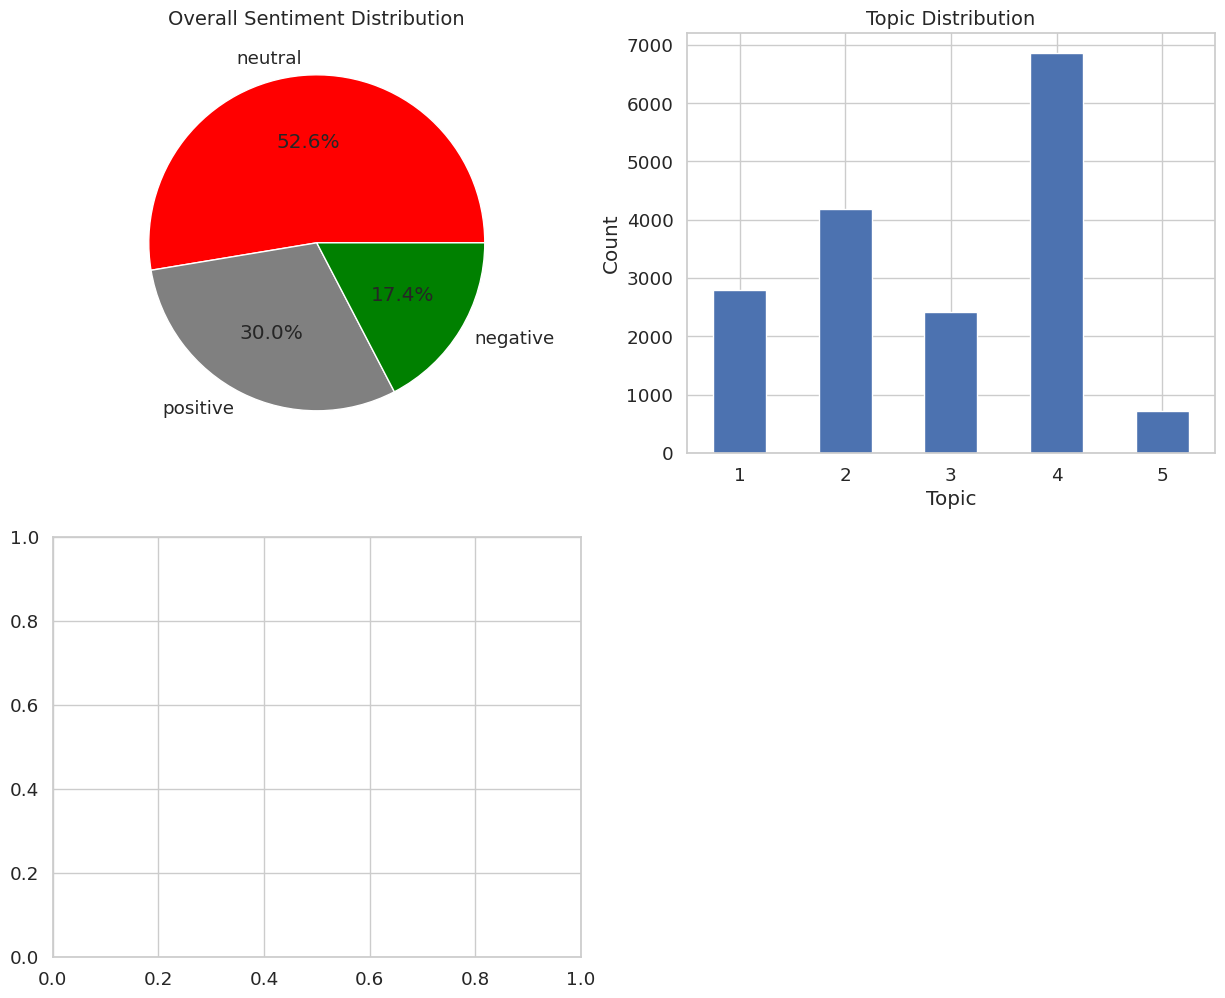

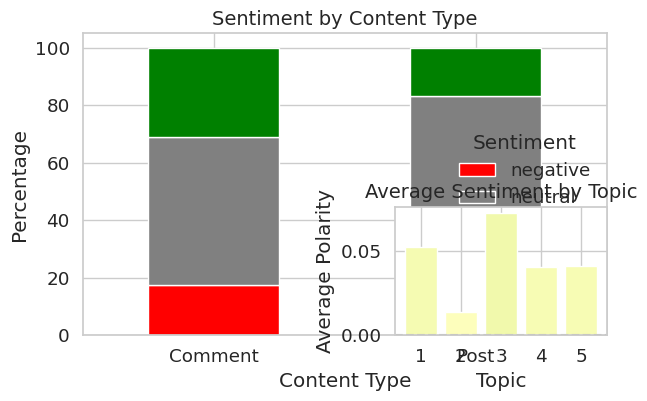

In [95]:
# Summary of Key Findings
# Generate summary statistics for the final report
# Overall sentiment distribution
print("Overall Sentiment Distribution:")
sentiment_summary = reddit_data_df['sentiment_category'].value_counts(normalize=True) * 100
print(sentiment_summary)

# Most common words overall
print("\nTop 20 Most Common Words:")
print(pd.DataFrame(most_common_words[:20], columns=['Word', 'Count']))

# Topic summary
print("\nIdentified Topics:")
for i, topic_words in enumerate(lda_topics):
    print(f"Topic {i+1}: {', '.join(topic_words[:10])}")

# Sentiment by content type
print("\nSentiment by Content Type:")
content_type_sentiment_summary = pd.crosstab(
    reddit_data_df['is_comment'].map({True: 'Comment', False: 'Post'}),
    reddit_data_df['sentiment_category'],
    normalize='index'
) * 100
print(content_type_sentiment_summary)

# Sentiment by subreddit (top 5)
print("\nSentiment by Top 5 Subreddits:")
top5_subreddits = reddit_data_df['subreddit'].value_counts().head(5).index
subreddit_sentiment_summary = pd.crosstab(
    reddit_data_df['subreddit'],
    reddit_data_df['sentiment_category'],
    normalize='index'
) * 100
print(subreddit_sentiment_summary.loc[top5_subreddits])

# Create a comprehensive summary visualization
plt.figure(figsize=(15, 12))

# 1. Overall sentiment distribution
plt.subplot(2, 2, 1)
sentiment_counts = reddit_data_df['sentiment_category'].value_counts()
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['red', 'gray', 'green'])
plt.title('Overall Sentiment Distribution', fontsize=14)
plt.ylabel('')

# 2. Topic distribution
plt.subplot(2, 2, 2)
reddit_data_df['dominant_topic'].value_counts().sort_index().plot(kind='bar')
plt.title('Topic Distribution', fontsize=14)
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 3. Sentiment by content type
plt.subplot(2, 2, 3)
content_type_sentiment = pd.crosstab(
    reddit_data_df['is_comment'].map({True: 'Comment', False: 'Post'}),
    reddit_data_df['sentiment_category']
)
content_type_sentiment_pct = content_type_sentiment.div(content_type_sentiment.sum(axis=1), axis=0) * 100
content_type_sentiment_pct.plot(kind='bar', stacked=True, color=['red', 'gray', 'green'])
plt.title('Sentiment by Content Type', fontsize=14)
plt.xlabel('Content Type')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')

# 4. Average polarity by topic
plt.subplot(2, 2, 4)
topic_polarity = reddit_data_df.groupby('dominant_topic')['polarity'].mean()
bars = plt.bar(topic_polarity.index, topic_polarity, color=plt.cm.RdYlGn(0.5 + topic_polarity/2))
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.title('Average Sentiment by Topic', fontsize=14)
plt.xlabel('Topic')
plt.ylabel('Average Polarity')
plt.xticks(topic_polarity.index)

plt.tight_layout()
plt.savefig('uyghur_reddit_sentiment_summary.png', dpi=300, bbox_inches='tight')
plt.show()